## Notebook for single cell photostimulation experiments regarding OPSF vs PPSF

In [2]:
%run ./rob_setup_notebook.ipynb

from utils.paq2py import *
from utils import sta
from utils.utils_funcs_ppsf_vs_opsf import *
from ScanImageTiffReader import ScanImageTiffReader
from read_roi import read_roi_zip
import gc
from scipy.interpolate import interp1d
from scipy.signal import chirp, find_peaks, peak_widths

from read_roi import read_roi_zip, read_roi_file
from matplotlib.path import Path

fig_dir = os.path.join(fig_save_path, 'OPSF_vs_PPSF', '')
fig_save_path = os.path.join(fig_save_path, 'OPSF_vs_PPSF', 'opsf_vs_ppsf')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Suite2p path: ['/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Figures 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


# Make OPSF curves from raw data

Resolution: Large, FWHM: 18.592010082434562
Resolution: Small, FWHM: 8.280168335404746


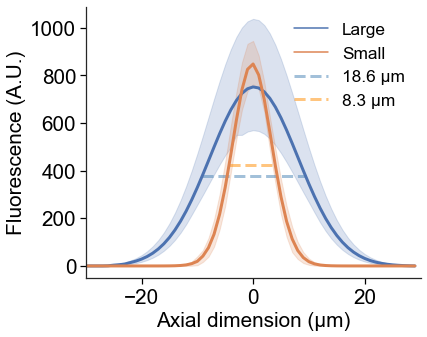

In [4]:
parent_dir = os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'OPSF')
file_list = os.listdir(parent_dir)

# construct dataframe
opsf_df = pd.DataFrame()

for i, file in enumerate(file_list):
    temp_df = pd.read_csv(os.path.join(parent_dir, file))
    
    temp_df['Resolution'] = 'Large' if 'NA0.3' in file else 'Small'
    temp_df['Bead'] = i
    opsf_df = pd.concat([opsf_df, temp_df])

#rename things that are difficult to index
opsf_df.rename(columns={'Distance (µm)' : 'Axial dimension'}, inplace=True)

#pivot so that we can apply a shift to centre all of the curves
pivot_df = opsf_df.pivot(index='Axial dimension', columns=['Bead', 'Resolution'], values='Fitted_data')

aligned_df = pivot_df.apply(lambda col: col.shift(30 - col.idxmax()))
aligned_df = aligned_df.melt(value_name='Fluorescence (A.U.)') #re-melt the data back to long-form

#sort out the dataframe for plotting
aligned_df['Fluorescence (A.U.)'] = aligned_df['Fluorescence (A.U.)'] - 32767 #change 16-bit unsigned to signed 
aligned_df['Axial dimension'] = np.tile(np.arange(-30,30), 7) #make the x axis

#subtract minimum from the curves to make it look nice 
aligned_df['Fluorescence (A.U.)'] = aligned_df['Fluorescence (A.U.)'] - aligned_df.groupby('Bead')['Fluorescence (A.U.)'].transform('min')
aligned_df.replace(np.nan, 0, inplace=True) #replace nans to extend curve to edges

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,5))

sns.lineplot(data=aligned_df, x='Axial dimension', y='Fluorescence (A.U.)', hue='Resolution', ax=ax,
            linewidth=3);

plt.sca(ax)

color = {'Large':'steelblue', 'Small':'darkorange'}

#find FWHM values for the mean curves
for res in ['Large', 'Small']:
    mean_curve = aligned_df.query('Resolution == @res').groupby('Axial dimension').mean()['Fluorescence (A.U.)']

    y = mean_curve.to_numpy()
    x = np.arange(-30,30)

    peaks, _ = find_peaks(y, height=(np.nanmax(y)))
    results_half = peak_widths(y, peaks, rel_height=0.5)
    fwhm = results_half[0]
    
    plt.hlines(results_half[1], results_half[2]-30, results_half[3]-30, linewidth=3,
               linestyle='--', color=color[res], alpha=0.5, label=f'{fwhm[0]:.1f} µm')
    plt.xlabel('Axial dimension (µm)')

    
    print(f'Resolution: {res}, FWHM: {fwhm[0]}')

ax.legend(frameon = False);
ax.set_xlim([-30, 30])

save_path = fig_save_path + '_PSF_curves_FWHM'
savePlot(save_path)

# Power tests

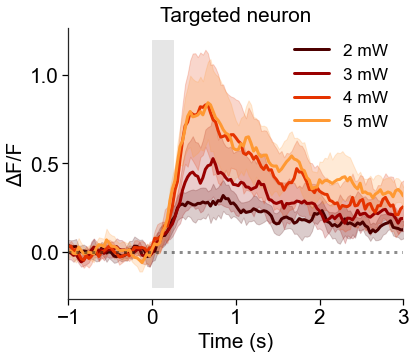

In [5]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_2', 'power_test_curves.npy'))
all_powers = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_2', 'powers.npy'), allow_pickle=True)

power_test_df = pd.DataFrame({'ΔF/F': all_traces.flatten(),
                              'Power': np.repeat(all_powers, len(all_traces[0])),
                              'Time (s)' : np.tile(np.arange(0,150) - 40, 38) * 0.0303,
                              'Cell' : np.repeat(np.arange(0,len(all_traces)), len(all_traces[0]))
                            })

smoothed_dff = power_test_df.groupby(['Cell', 'Power']).rolling(5, min_periods=1).mean()['ΔF/F']

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,5))

sns.lineplot(data=power_test_df, x='Time (s)', y=smoothed_dff.to_numpy(), ax=ax, linewidth=3,
             hue='Power', estimator='mean', ci=95, palette=sns.color_palette('gist_heat', 4))

ax.set_ylabel('ΔF/F');

# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-0.2), 0.250, 1.4, zorder=-1, color='0.9')
ax.add_patch(stim_patch)

ax.hlines(0, -1.2, 3.3, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
ax.legend(['2 mW', '3 mW', '4 mW', '5 mW'], frameon=False);
ax.set_title('Targeted neuron')
ax.set_xlim([-1, 3])

save_path = fig_save_path + '_power_test_responses'
savePlot(save_path)

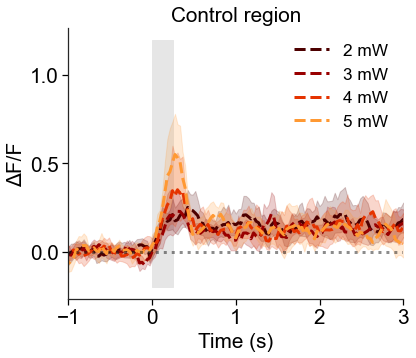

In [461]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_2', 'power_test_curves_control.npy'))
all_powers = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_2', 'powers_control.npy'), allow_pickle=True)

power_test_df = pd.DataFrame({'ΔF/F': all_traces.flatten(),
                              'Power': np.repeat(all_powers, len(all_traces[0])),
                              'Time (s)' : np.tile(np.arange(0,150) - 40, 38) * 0.0303,
                              'Cell' : np.repeat(np.arange(0,len(all_traces)), len(all_traces[0]))
                            })

smoothed_dff = power_test_df.groupby(['Cell', 'Power']).rolling(5, min_periods=1).mean()['ΔF/F']

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,5))

sns.lineplot(data=power_test_df, x='Time (s)', y=smoothed_dff.to_numpy(), ax=ax, linewidth=3, linestyle='dashed',
             hue='Power', estimator='mean', ci=95, palette=sns.color_palette('gist_heat', 4))

ax.set_ylabel('ΔF/F');

# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-0.2), 0.250, 1.4, zorder=-1, color='0.9')
ax.add_patch(stim_patch)

ax.hlines(0, -1.2, 3.3, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
ax.legend(['2 mW', '3 mW', '4 mW', '5 mW'], frameon=False);
ax.set_title('Control region')
ax.set_xlim([-1, 3])

save_path = fig_save_path + '_power_test_responses_control'
savePlot(save_path)

# Spiral speed

Result for t-test: Ttest_indResult(statistic=-1.0651443097433333, pvalue=0.29319817026744827)


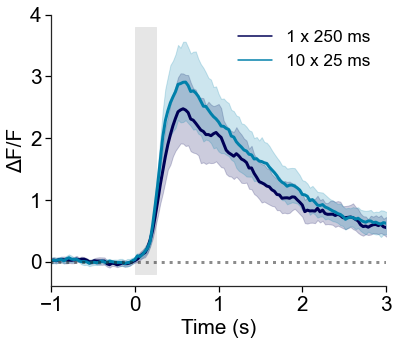

In [14]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'SlowFast_spirals_data', 'spiral_curves.npy'))

# 24 x 2 x 150, cell x speed x frame, speed = 0: slow, 1: fast

speed_test_df = pd.DataFrame({'ΔF/F': all_traces.flatten(),
                              'Speed': np.tile(np.repeat(['1 x 250 ms', '10 x 25 ms'], all_traces.shape[2]), all_traces.shape[0]),
                              'Time (s)' : np.tile(np.arange(0,150) - 40, 2*all_traces.shape[0]) * 0.0303,
                              'Cell' : np.repeat(np.arange(0, all_traces.shape[0]), 2*all_traces.shape[2])
                            })

smoothed_dff = speed_test_df.groupby(['Cell', 'Speed']).rolling(5, min_periods=1).mean()['ΔF/F']

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,5))

sns.lineplot(data=speed_test_df, x='Time (s)', y=smoothed_dff.to_numpy(), ax=ax, linewidth=3,
             hue='Speed', estimator='mean', ci=95, palette=sns.color_palette('ocean', 2))

ax.set_ylabel('ΔF/F');

# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-0.2), 0.250, 4, zorder=-1, color='0.9')
ax.add_patch(stim_patch)

ax.hlines(0, -1.2, 3.3, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
ax.legend(frameon=False);
ax.set_xlim([-1, 3])

save_path = fig_save_path + '_spiral_speed_test_responses'
savePlot(save_path)

post_stim_df = speed_test_df[(speed_test_df['Time (s)'] > 0.45) & (speed_test_df['Time (s)'] < 1.79)]
mean_post_stim = post_stim_df.groupby(['Cell', 'Speed']).agg(np.nanmean)

fast = mean_post_stim.query('Speed == "1 x 250 ms"')['ΔF/F'].dropna().to_numpy()
slow = mean_post_stim.query('Speed == "10 x 25 ms"')['ΔF/F'].dropna().to_numpy()
print(f'Result for t-test: {stats.ttest_ind(fast, slow)}')

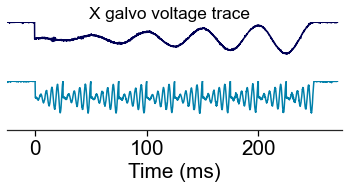

In [167]:
input_dir = os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'SlowFast_spirals_data')
fast_paq = paq_read(os.path.join(input_dir, 'Cell36', '2020-09-25_axialRes_PPSF_RL091_Cell36_NA0.73_fast_00001.paq'))
slow_paq = paq_read(os.path.join(input_dir, 'Cell36', '2020-09-25_axialRes_PPSF_RL091_Cell36_NA0.73_slow_00001.paq'))

slow_data = slow_paq['data'][0,239800:242800]
fast_data = fast_paq['data'][0,239000:242000]
time = (np.arange(0,3000)-288)/10

paq_df = pd.DataFrame({'Time (ms)' : np.tile(time, 2),
                       'Voltage' : np.hstack([slow_data, fast_data]),
                       'Speed' : np.repeat(['1 x 250 ms', '10 x 25 ms'], 3000) 
                      }) 

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(6,2))

for ax, speed, color in zip(axes, ['1 x 250 ms', '10 x 25 ms'], sns.color_palette('ocean', 2)):
    speed_df = paq_df.query('Speed == @speed')
    sns.lineplot(data=speed_df, x='Time (ms)', y='Voltage', ax=ax, color=color)
    ax.set_ylabel('')
    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim([0, 0.25])
    
axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))

# plt.suptitle('X galvo voltage trace', fontsize='x-large')
axes[0].set_xlim([-25, 275])
axes[0].get_xaxis().set_visible(False)
axes[0].spines['bottom'].set_visible(False)

save_path = fig_save_path + '_spiral_speed_test_examples'
savePlot(save_path)

# Measuring physiological PSF

## Plot example cell

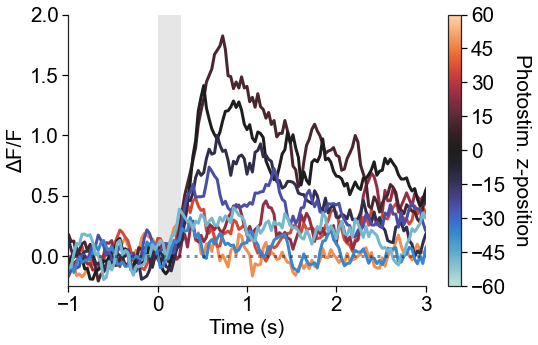

In [17]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_curves_corrected.npy'))
all_na = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_na_corrected.npy'), allow_pickle=True)

pos_i = [0, 1, 2, 3, 4, 6, 7, 8, 9]
all_traces = all_traces[:, pos_i, :]

example_trace = all_traces[0]

example_cell_df = pd.DataFrame({'ΔF/F': example_trace.flatten(),
                               'Time (s)' : np.tile(np.arange(0,150) - 40, example_trace.shape[0]) * 0.0303,
                               'Position' : np.repeat(np.arange(-60, 61, 15), example_trace.shape[1])
                               })

smoothed_dff = example_cell_df.groupby(['Position']).rolling(5, min_periods=1).mean()['ΔF/F']

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))

# colors = ['0.3', '0.4', '0.5', '0.6', '0.7', '0.6', '0.5', '0.4', '0.3']

sns.lineplot(data=example_cell_df, x='Time (s)', y=smoothed_dff.to_numpy(), ax=ax, linewidth=3,
             hue='Position', estimator='mean', ci=95, palette=sns.color_palette('icefire_r', 9), legend=False)

sm = plt.cm.ScalarMappable(cmap=sns.color_palette('icefire', as_cmap=True), norm=plt.Normalize(vmin=-60, vmax=60))
cbar = plt.colorbar(sm)
cbar.set_ticks(np.arange(-60, 61, 15))
cbar.ax.get_yaxis().labelpad = 25
cbar.set_label('Photostim. z-position', rotation=270)

ax.set_ylabel('ΔF/F');

# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-0.25), 0.250, 2.5, zorder=-1, color='0.9')
ax.add_patch(stim_patch)

ax.hlines(0, -1.2, 3.3, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
ax.set_ylim([-0.25, 2])
ax.set_xlim([-1, 3])

save_path = fig_save_path + '_example_cell_responses'
savePlot(save_path)

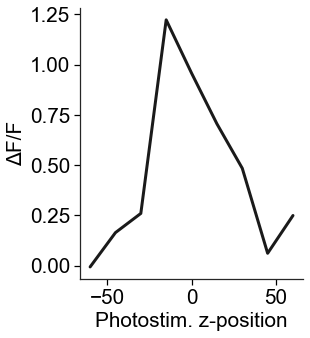

In [26]:
mean_post_stim = np.nanmean(example_trace[:, 55:100], axis=1)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 5))

sns.lineplot(x=np.arange(-60, 61, 15), y=mean_post_stim, ax=ax, linewidth=3,
             estimator='mean', color='k', ci=95);

ax.set_ylabel('ΔF/F')
ax.set_xlabel('Photostim. z-position');

save_path = fig_save_path + '_example_cell_curve'
savePlot(save_path)

## Plot all cells reverse, standard

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


Result for ('Large', -135) t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for ('Large', -120) t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for ('Large', -105) t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for ('Large', -90) t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for ('Large', -75) t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for ('Large', -60) t-test: Ttest_indResult(statistic=-0.6472177702033549, pvalue=0.5460275500440386)
Result for ('Large', -45) t-test: Ttest_indResult(statistic=1.334496485117781, pvalue=0.2049452913719088)
Result for ('Large', -30) t-test: Ttest_indResult(statistic=1.6921151034407893, pvalue=0.11443876678391304)
Result for ('Large', -15) t-test: Ttest_indResult(statistic=2.351521645931702, pvalue=0.035126302625607446)
Result for ('Large', 0) t-test: Ttest_indResult(statistic=1.0020713937694108, pvalue=0.3345971906589923)
Result for ('Large', 15) t-test: Ttest_indResult(statistic=0.1459059514664668

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


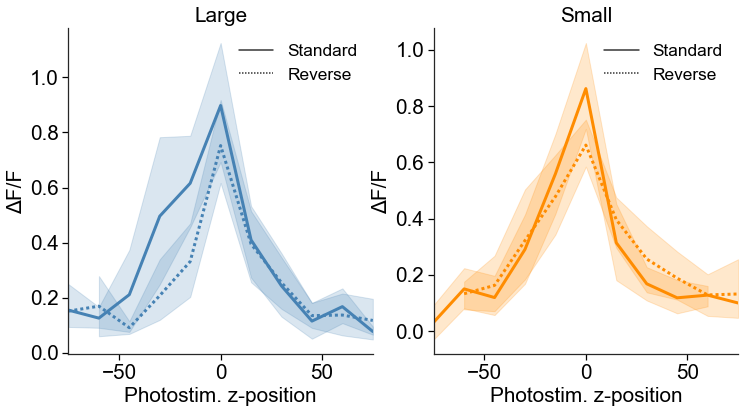

In [19]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_curves_corrected.npy'))
all_na = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_na_corrected.npy'), allow_pickle=True)
all_directions = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_directions_corrected.npy'), allow_pickle=True)

# cut out position 5 as it is not spaced well from the rest
pos_i = [0, 1, 2, 3, 4, 6, 7, 8, 9]
all_traces = all_traces[:, pos_i, :]

# get mean post stim values for all cells, only take responders
mean_post_stim = np.nanmean(all_traces[:, :, 55:100], axis=2)
responders = np.unique(np.where(mean_post_stim>0.5)[0])
mean_post_stim = mean_post_stim[responders]

all_na = all_na[responders]
all_directions = all_directions[responders]

# pad the curves to centre them by their max
mean_post_stim = np.pad(mean_post_stim, ((0,0), (5,5)), 'constant', constant_values=(np.nan, np.nan))
m,n = mean_post_stim.shape
row_shifts = n//2 - np.nanargmax(mean_post_stim, axis=1)
col_idx = np.mod(np.arange(n)[:, None]-row_shifts,n)
col_idx = col_idx.T

for position_i, (cell_post_stim, col_i) in enumerate(zip(mean_post_stim, col_idx)):
    mean_post_stim[position_i] = cell_post_stim[col_i]

# make dataframe
post_stim_df = pd.DataFrame({'ΔF/F': mean_post_stim.flatten(),
                             'Photostim. z-position' : np.tile(np.arange(135, -136, -15), mean_post_stim.shape[0]),
                             'Resolution' : np.repeat(all_na, mean_post_stim.shape[1]),
                             'Direction' : np.repeat(all_directions, mean_post_stim.shape[1]),
                             'Repeat' : np.repeat(np.arange(0, mean_post_stim.shape[0]), mean_post_stim.shape[1])
                            })

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

post_stim_df = post_stim_df.replace({'NA0.3' : 'Large',
                                     'NA0.5' : 'Small',
                                     'standard' : 'Standard',
                                     'reverse' : 'Reverse'
                                    })

color = {'Large': 'steelblue', 'Small': 'darkorange'}

for resolution, ax in zip(['Large', 'Small'], axes):
    
    resolution_df = post_stim_df.query('Resolution == @resolution')

    sns.lineplot(data=resolution_df, x='Photostim. z-position', y='ΔF/F', ax=ax, linewidth=3,
                 style='Direction', style_order=['Standard', '', 'Reverse'], estimator='mean', color=color[resolution], ci=95);
    ax.set_title(resolution)
    ax.legend(frameon=False)
    ax.set_xlim([-75, 75])

save_path = fig_save_path + '_all_cells_standard_reverse_curves'
savePlot(save_path)

# Stats test

high_low_df = post_stim_df.query('Resolution != "NA0.73"')

for name, position_df in high_low_df.groupby(['Resolution', 'Photostim. z-position']):
    standard = position_df.query('Direction == "Standard"')['ΔF/F'].dropna().to_numpy()
    reverse = position_df.query('Direction == "Reverse"')['ΔF/F'].dropna().to_numpy()
    print(f'Result for {name} t-test: {stats.ttest_ind(standard, reverse)}')

## Plot all cells combined (half curve)

Result for 0 t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for 15 t-test: Ttest_indResult(statistic=-0.5278059440380052, pvalue=0.5995806127740912)
Result for 30 t-test: Ttest_indResult(statistic=0.45451714027186624, pvalue=0.6510968114343122)
Result for 45 t-test: Ttest_indResult(statistic=-0.826282331327389, pvalue=0.4119176948332066)
Result for 60 t-test: Ttest_indResult(statistic=0.33221659702597217, pvalue=0.7414182370788924)
Result for 75 t-test: Ttest_indResult(statistic=0.37810422065209076, pvalue=0.7100329463229654)
Result for 90 t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for 105 t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for 120 t-test: Ttest_indResult(statistic=nan, pvalue=nan)
Result for 135 t-test: Ttest_indResult(statistic=nan, pvalue=nan)


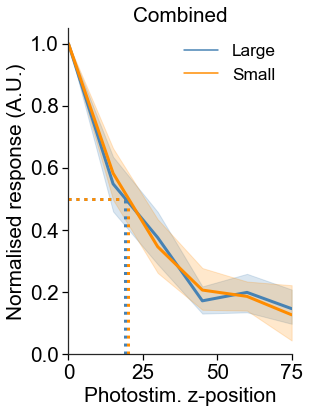

In [108]:
high_low_df = post_stim_df.query('Resolution != "NA0.73"').copy()

high_low_df['ΔF/F'] = high_low_df['ΔF/F'] / high_low_df.groupby(['Resolution', 'Repeat']).transform('max')['ΔF/F']

high_low_df = high_low_df.replace({-135 : 135,
                                   -120 : 120,
                                   -105 : 105,
                                   -90 : 90,
                                   -75 : 75,
                                   -60 : 60,
                                   -45 : 45,
                                   -30 : 30,
                                   -15 : 15
                                  })

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 6))

color = ['steelblue', 'darkorange']

sns.lineplot(data=high_low_df, x='Photostim. z-position', y='ΔF/F', ax=ax, linewidth=3,
             hue='Resolution', estimator='mean', palette=sns.color_palette(color), ci=95);
ax.legend(frameon=False);
ax.set_title('Combined')
ax.set_xlim([0, 75])
ax.set_ylim([0, 1.05])
ax.set_ylabel('Normalised response (A.U.)')

ax.hlines(0.5, 0, 19, linewidth=3, linestyle='dotted', color='steelblue')
ax.hlines(0.5, 0, 20, linewidth=3, linestyle='dotted', color='darkorange')
ax.vlines(19, 0, 0.5, linewidth=3, linestyle='dotted', color='steelblue')
ax.vlines(20, 0, 0.5, linewidth=3, linestyle='dotted', color='darkorange')

save_path = fig_save_path + '_all_cells_combined_curves'
savePlot(save_path)

for name, position_df in high_low_df.groupby(['Photostim. z-position']):
    low = position_df.query('Resolution == "Large"')['ΔF/F'].dropna().to_numpy()
    high = position_df.query('Resolution == "Small"')['ΔF/F'].dropna().to_numpy()
    print(f'Result for {name} t-test: {stats.ttest_ind(low, high)}')

# Plot control curves

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


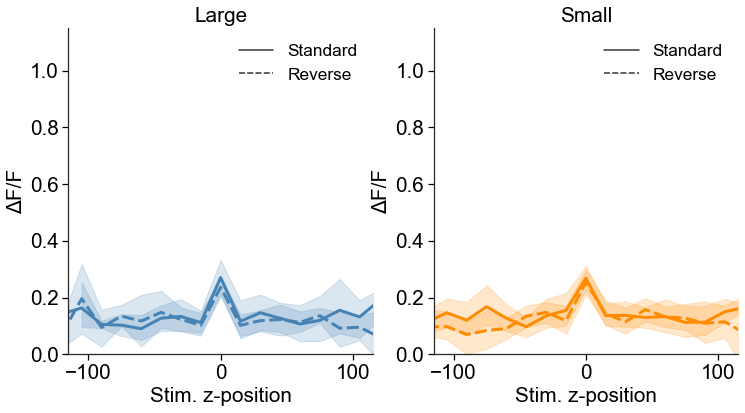

In [101]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_curves_control.npy'))
all_na = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_na_control.npy'), allow_pickle=True)
all_directions = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_directions_control.npy'), allow_pickle=True)

# cut out position 5 as it is not spaced well from the rest
pos_i = [0, 1, 2, 3, 4, 6, 7, 8, 9]
all_traces = all_traces[:, pos_i, :]

# get mean post stim values for all cells, only take responders
mean_post_stim = np.nanmean(all_traces[:, :, 55:100], axis=2)
responders = np.unique(np.where(mean_post_stim>0)[0])
mean_post_stim = mean_post_stim[responders]

all_na = all_na[responders]
all_directions = all_directions[responders]

# pad the curves to centre them by their max
mean_post_stim = np.pad(mean_post_stim, ((0,0), (5,5)), 'constant', constant_values=(np.nan, np.nan))
m,n = mean_post_stim.shape
row_shifts = n//2 - np.nanargmax(mean_post_stim, axis=1)
col_idx = np.mod(np.arange(n)[:, None]-row_shifts,n)
col_idx = col_idx.T

for position_i, (cell_post_stim, col_i) in enumerate(zip(mean_post_stim, col_idx)):
    mean_post_stim[position_i] = cell_post_stim[col_i]

# make dataframe
post_stim_df = pd.DataFrame({'ΔF/F': mean_post_stim.flatten(),
                             'Stim. z-position' : np.tile(np.arange(135, -136, -15), mean_post_stim.shape[0]),
                             'Resolution' : np.repeat(all_na, mean_post_stim.shape[1]),
                             'Direction' : np.repeat(all_directions, mean_post_stim.shape[1]),
                             'Repeat' : np.repeat(np.arange(0, mean_post_stim.shape[0]), mean_post_stim.shape[1])
                            })

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

post_stim_df = post_stim_df.replace({'NA0.3' : 'Large',
                                     'NA0.5' : 'Small',
                                     'standard' : 'Standard',
                                     'reverse' : 'Reverse'
                                    })

color = {'Large': 'steelblue', 'Small': 'darkorange'}

for resolution, ax in zip(['Large', 'Small'], axes):
    
    resolution_df = post_stim_df.query('Resolution == @resolution')

    sns.lineplot(data=resolution_df, x='Stim. z-position', y='ΔF/F', ax=ax, linewidth=3,
                 style='Direction', estimator='mean', color=color[resolution], ci=95);
    ax.set_title(resolution)
    ax.legend(frameon=False)
    ax.set_ylim([0, 1.15])
    ax.set_xlim([-115, 115])

save_path = fig_save_path + '_control_standard_reverse_curves'
savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


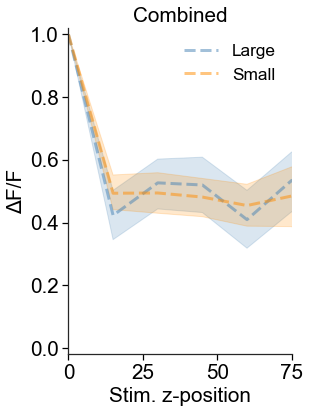

In [102]:
high_low_df = post_stim_df.query('Resolution != "NA0.73"')

high_low_df['ΔF/F'] = high_low_df['ΔF/F'] / high_low_df.groupby(['Resolution', 'Repeat']).transform('max')['ΔF/F']

high_low_df = high_low_df.replace({-135 : 135,
                                   -120 : 120,
                                   -105 : 105,
                                   -90 : 90,
                                   -75 : 75,
                                   -60 : 60,
                                   -45 : 45,
                                   -30 : 30,
                                   -15 : 15
                                  })

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 6))

color = ['steelblue', 'darkorange']

sns.lineplot(data=high_low_df, x='Stim. z-position', y='ΔF/F', ax=ax, linewidth=3, linestyle='dashed', alpha=0.5,
             hue='Resolution', estimator='mean', palette=sns.color_palette(color), ci=95);

ax.set_title('Combined')
ax.set_ylim([-0.02, 1.02])
ax.set_xlim([0, 75])

h = plt.gca().get_lines()
lg = plt.legend(handles=h, labels=['Large', 'Small'], loc='best', frameon=False)

save_path = fig_save_path + '_control_combined_curves'
savePlot(save_path)

### Find scanimage metadata

In [5]:
input_dir = os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Axial_res_PPSF_data_3', 'Cell29')
f = '2020-11-20_axialRes_PPSF_RL111_Cell29_NA0.3_standard_00001.tif'
cell_stack = ScanImageTiffReader(os.path.join(input_dir, f))
print(cell_stack.metadata())

### Make folders

In [4]:
cells_to_analyse = np.arange(59,78)

for cell in cells_to_analyse:
    input_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_3', 'Cell' + str(cell))
    output_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_3', 'Cell' + str(cell))
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
# Move files?

parent_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_3')

file_list = os.listdir(parent_dir)
file_list.sort()

for file in file_list:
    if any(s in file for s in ['.tif', '.paq']):
        cell_num = file.split('_')[4]
        os.rename(os.path.join(parent_dir, file), os.path.join(parent_dir, cell_num, file))

### Universal processing for single cells PPSF vs. OPSF data (multi trial)

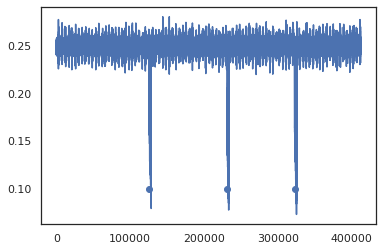

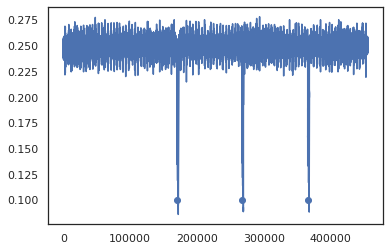

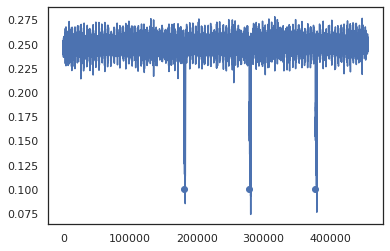

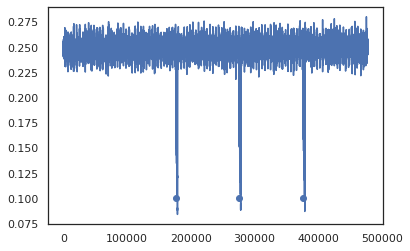

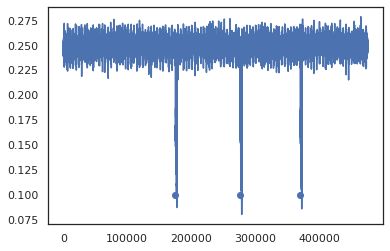

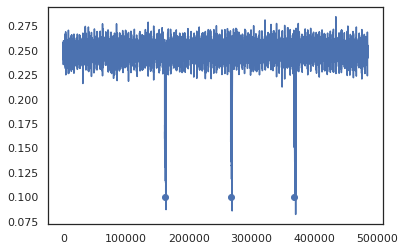

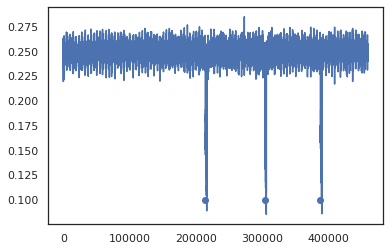

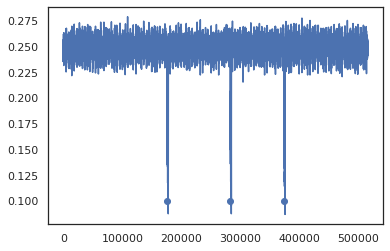

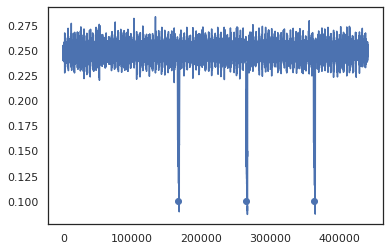

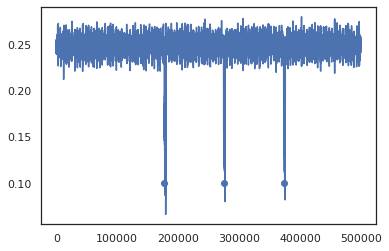

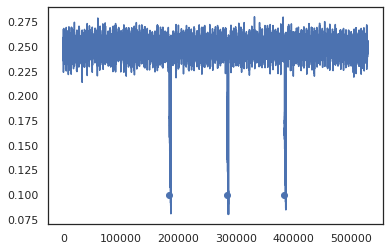

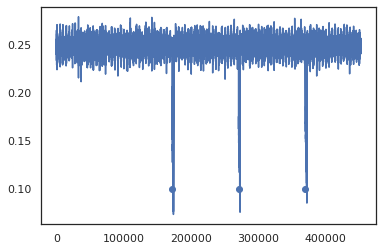

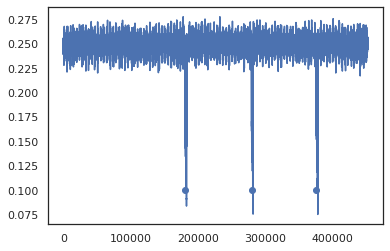

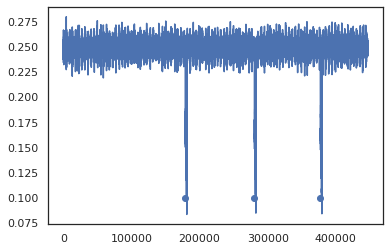

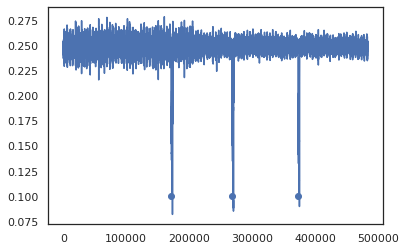

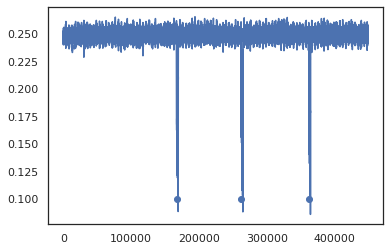

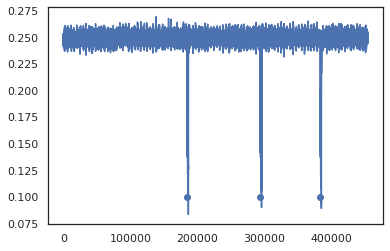

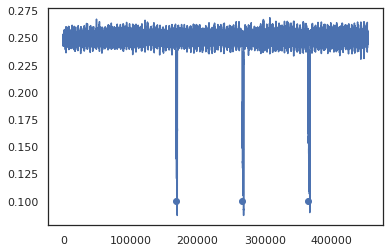

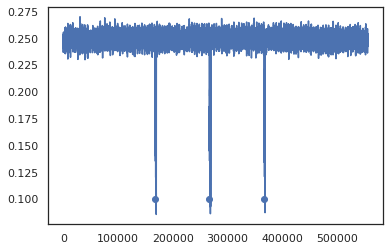

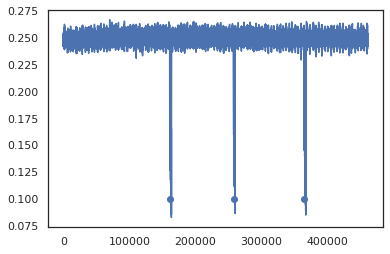

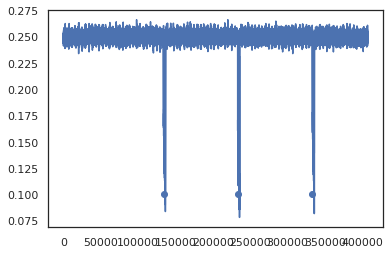

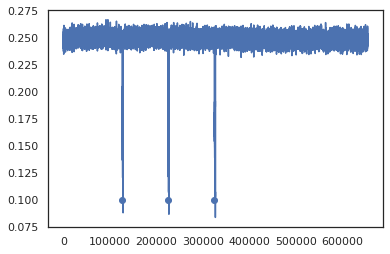

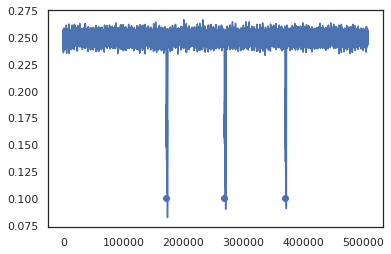

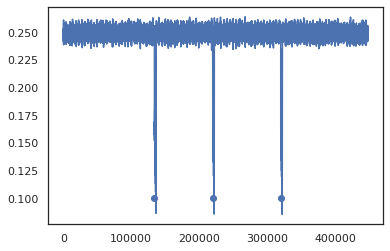

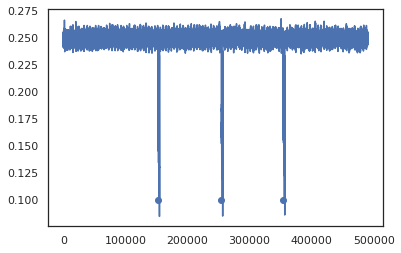

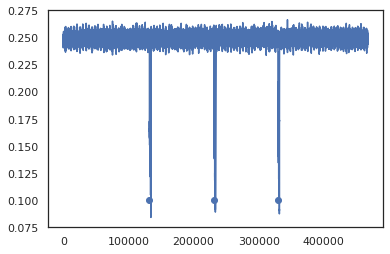

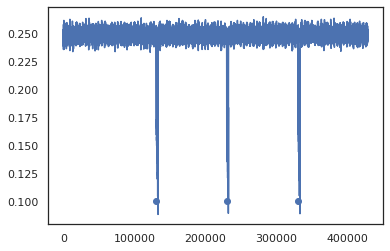

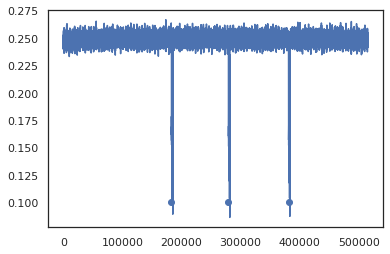

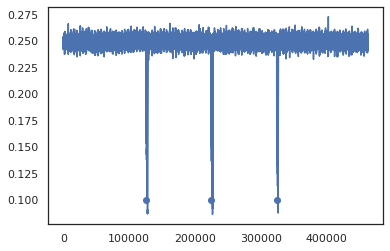

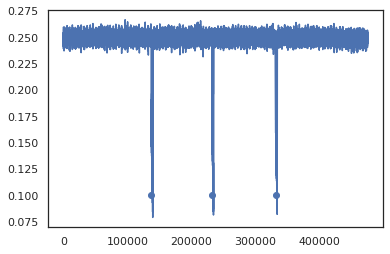

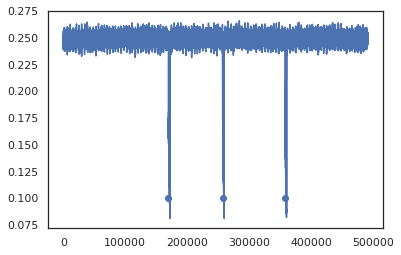

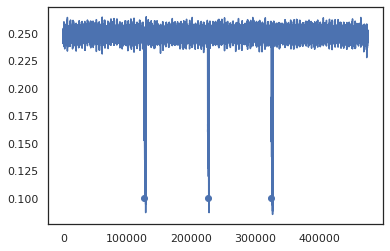

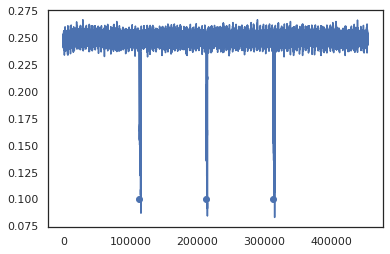

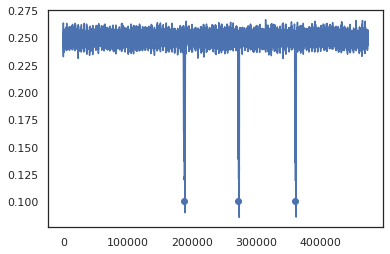

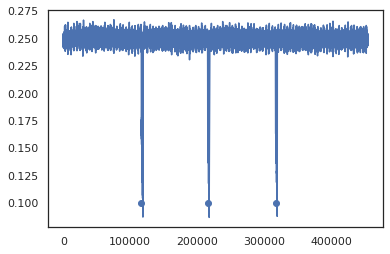

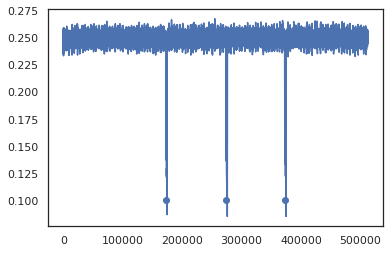

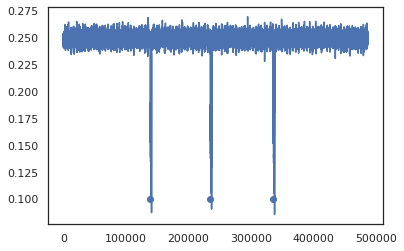

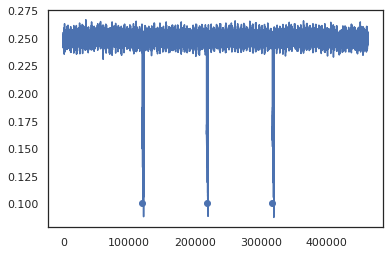

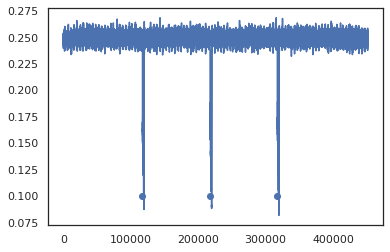

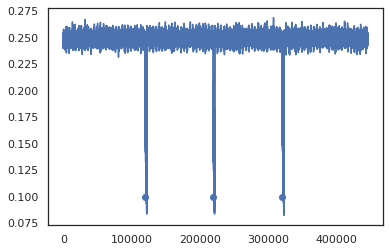

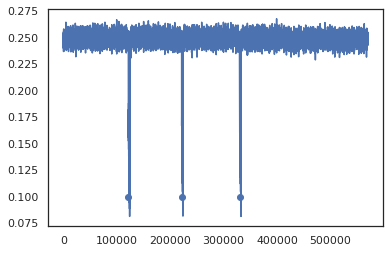

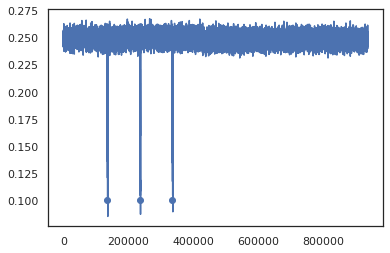

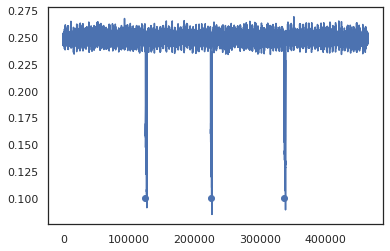

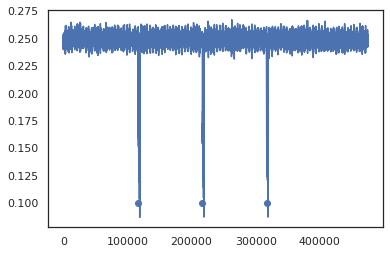

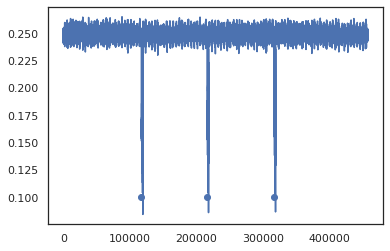

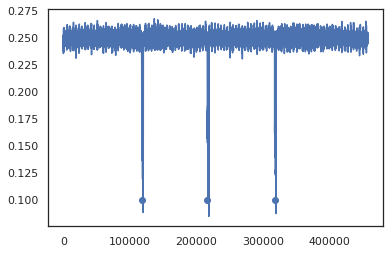

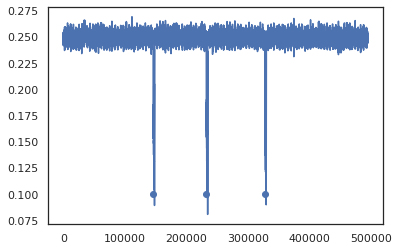

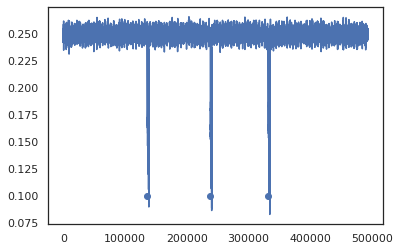

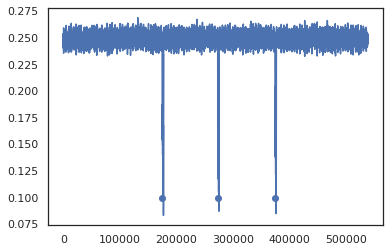

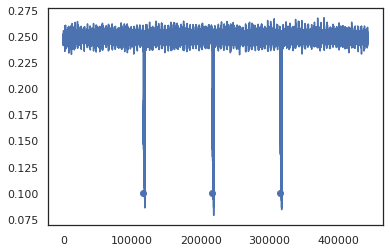

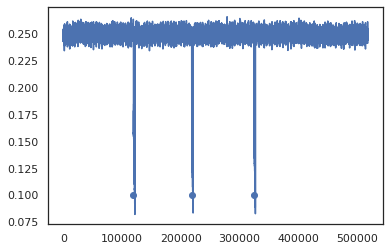

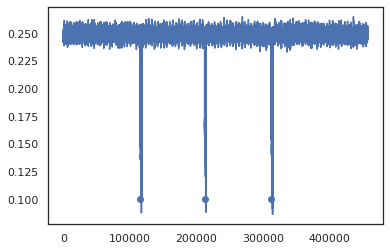

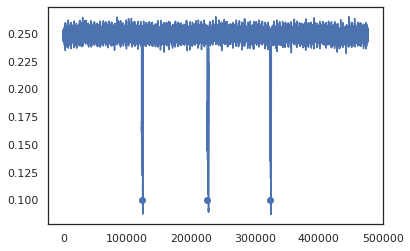

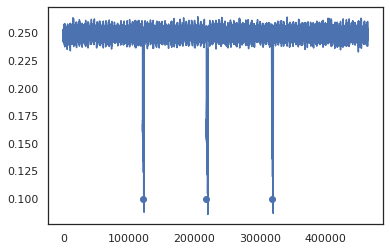

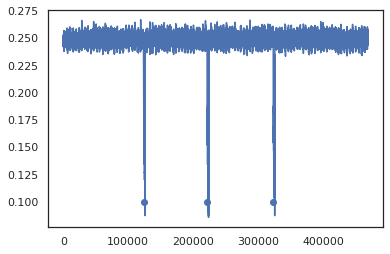

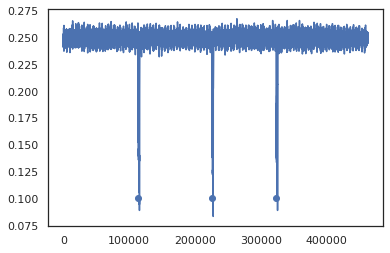

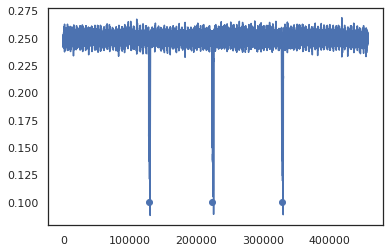

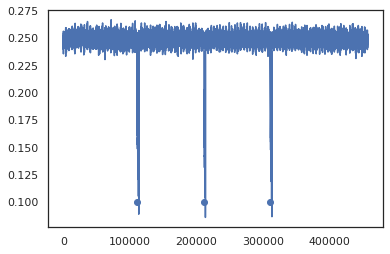

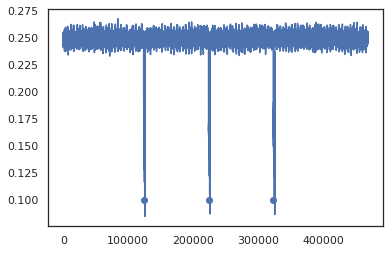

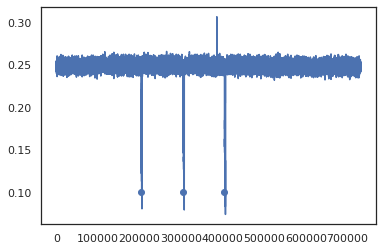

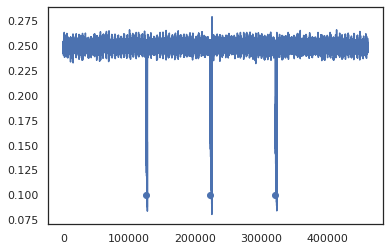

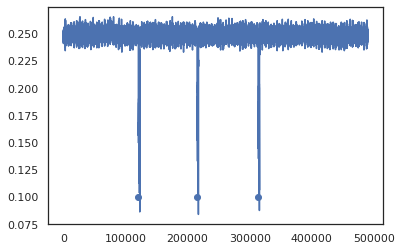

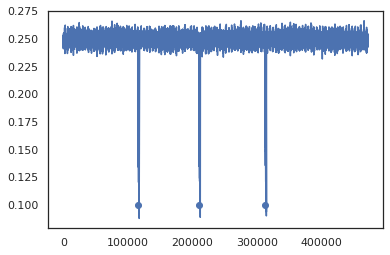

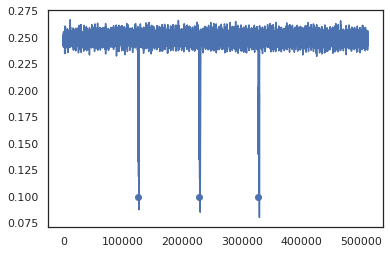

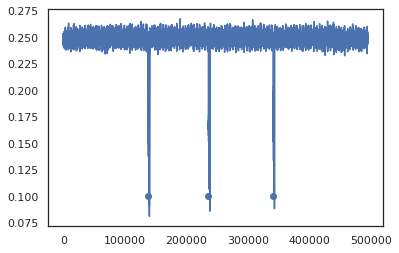

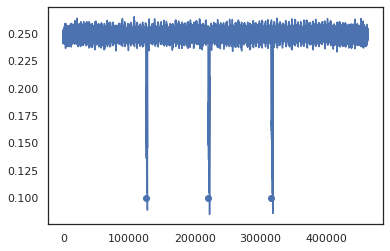

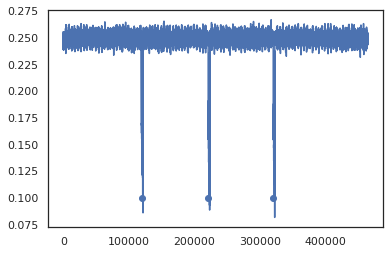

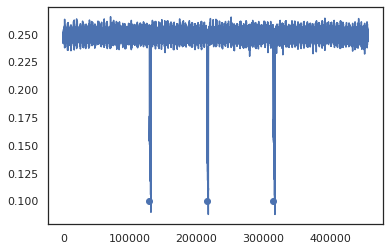

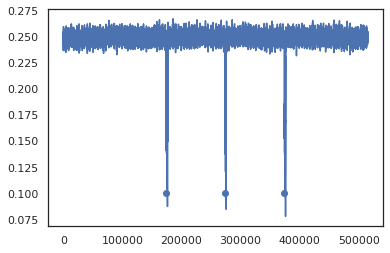

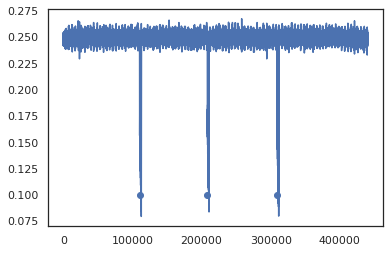

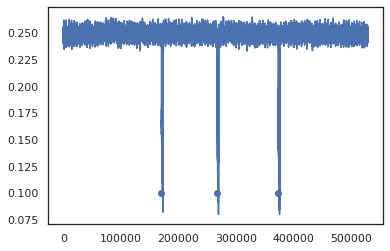

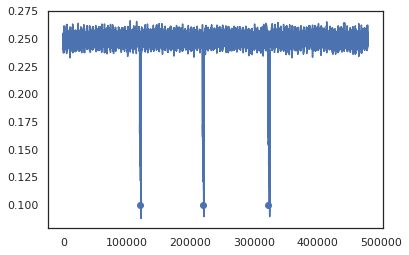

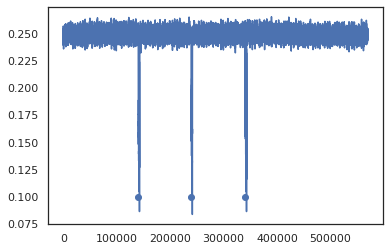

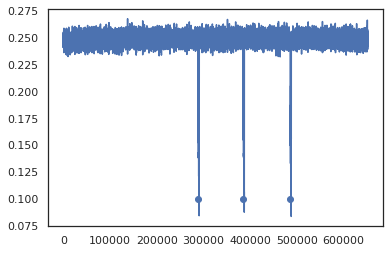

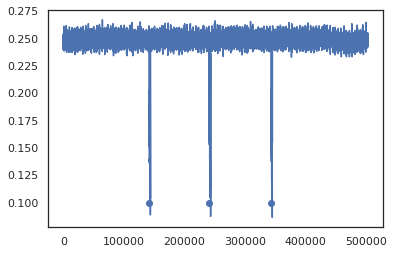

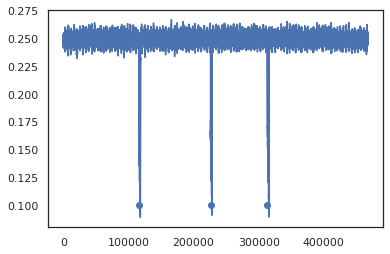

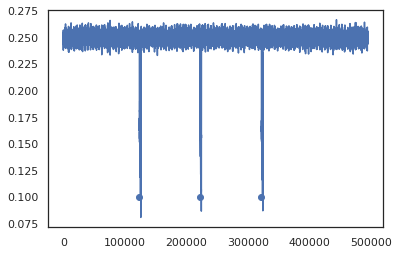

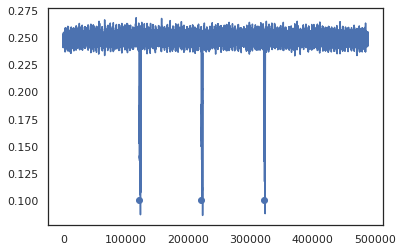

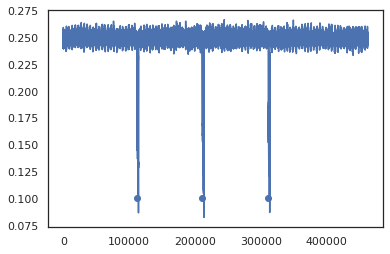

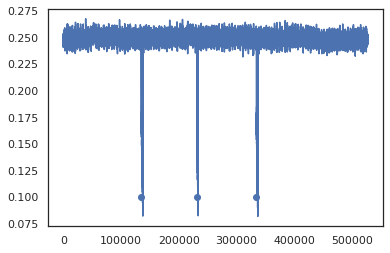

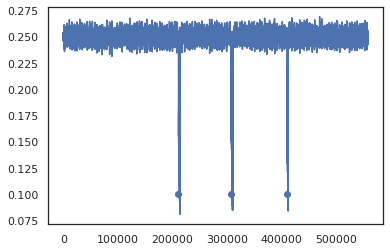

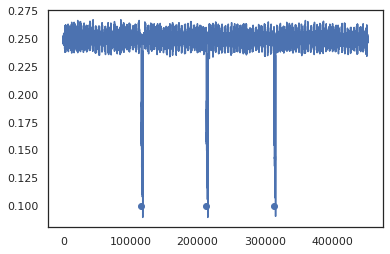

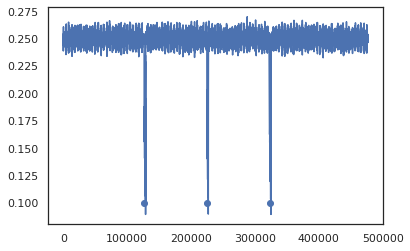

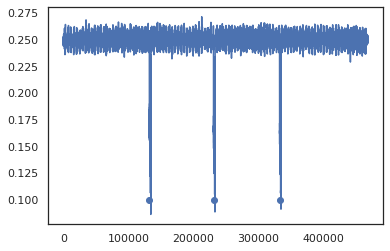

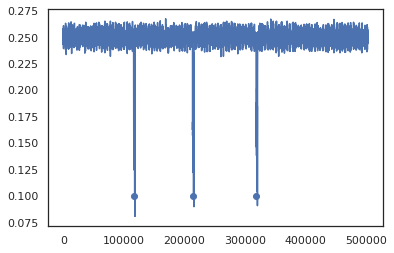

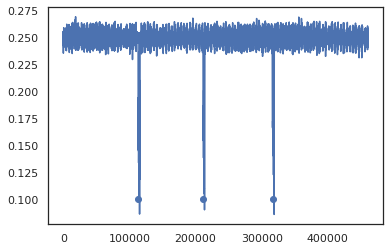

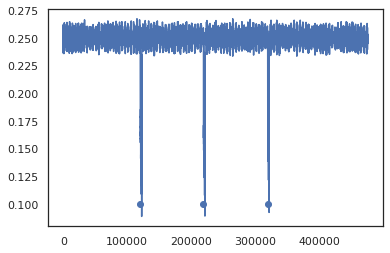

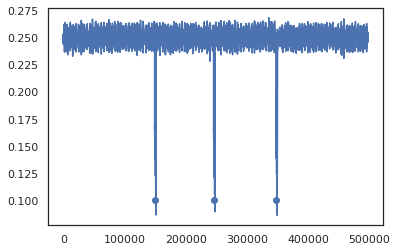

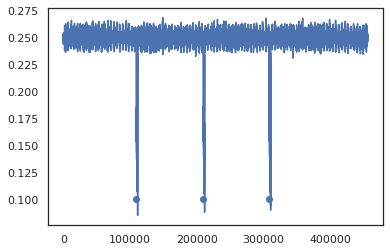

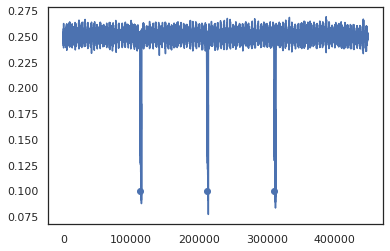

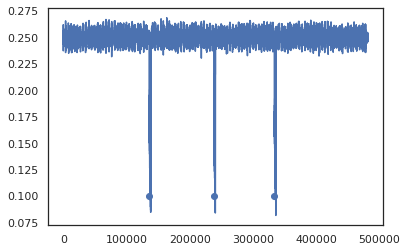

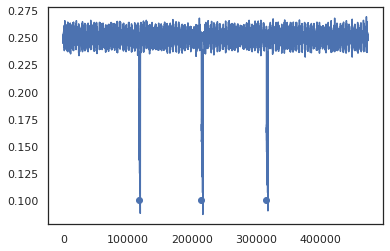

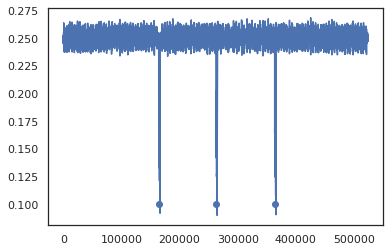

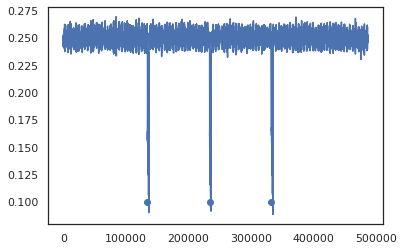

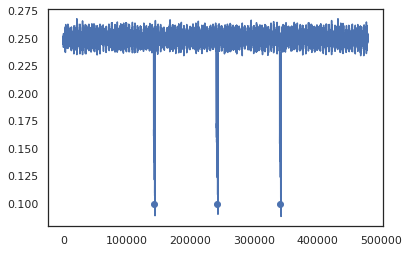

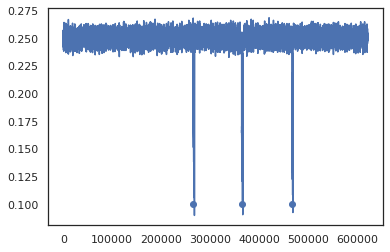

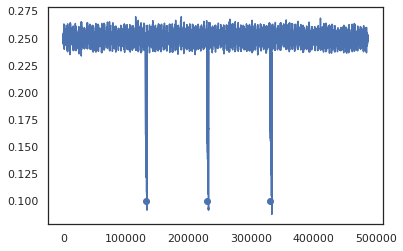

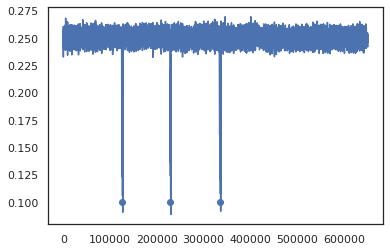

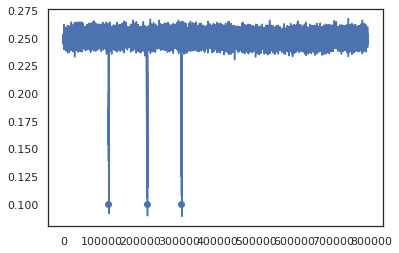

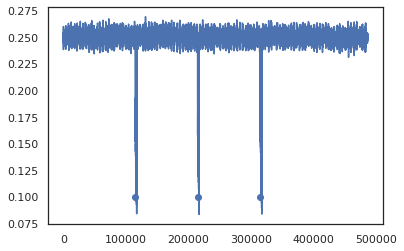

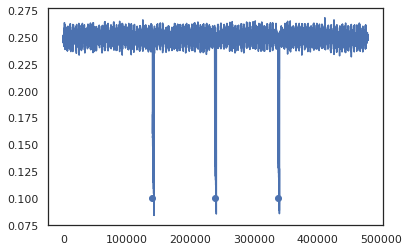

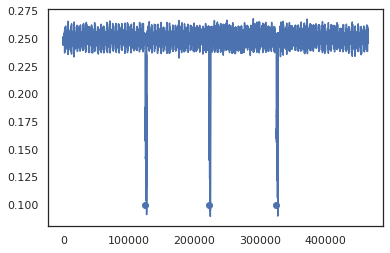

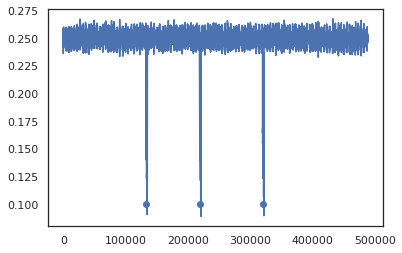

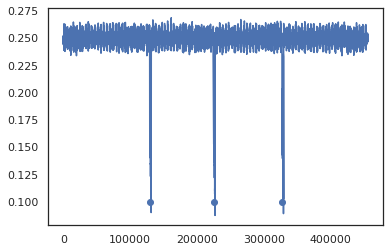

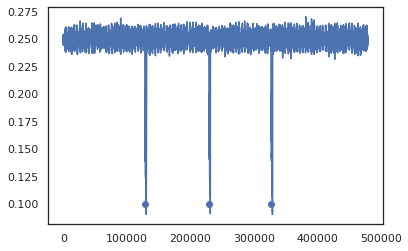

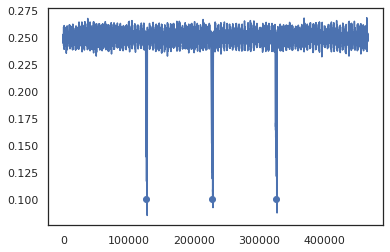

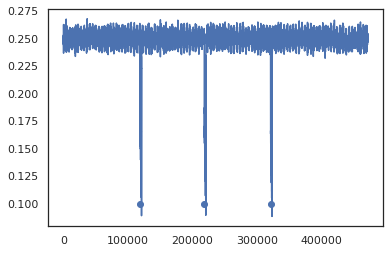

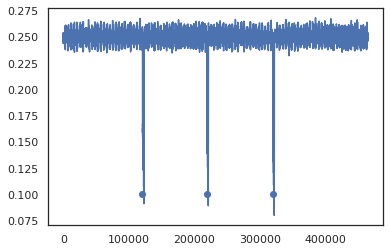

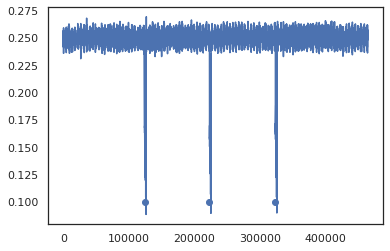

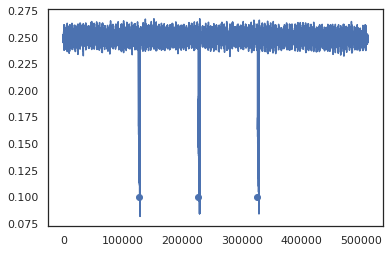

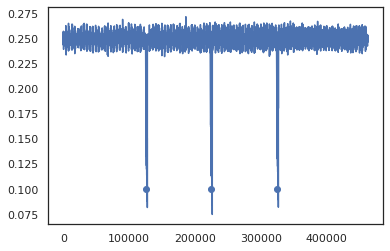

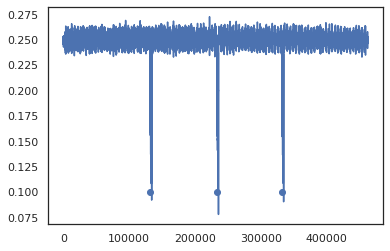

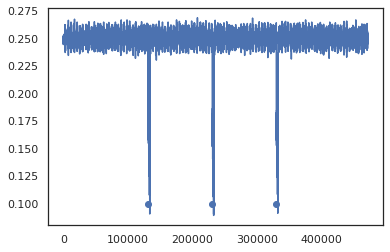

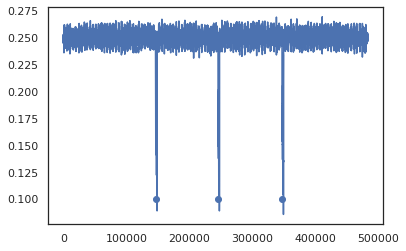

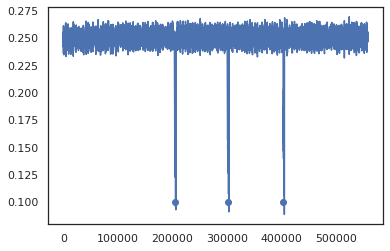

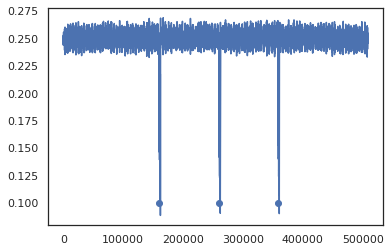

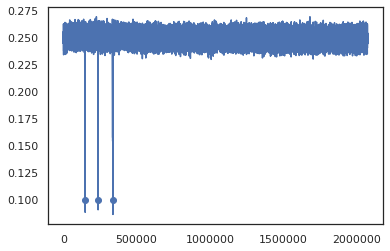

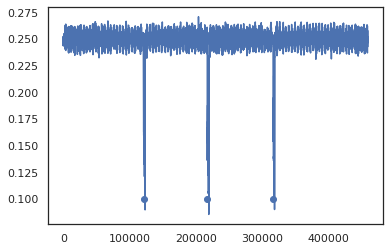

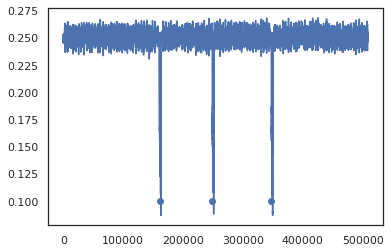

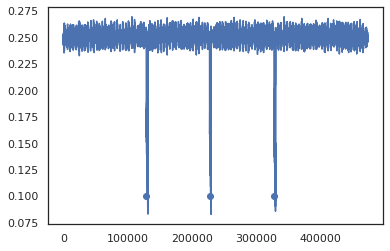

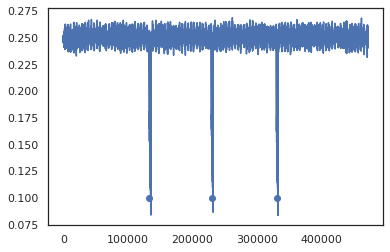

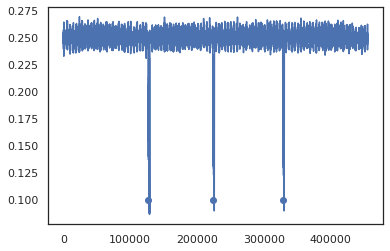

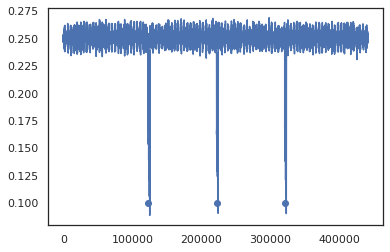

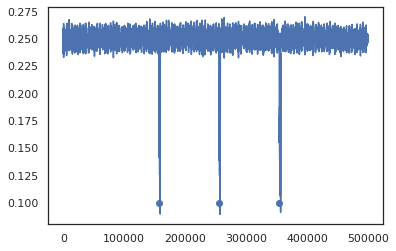

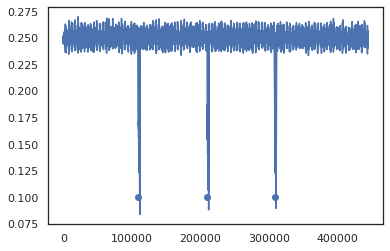

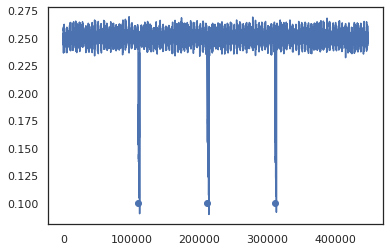

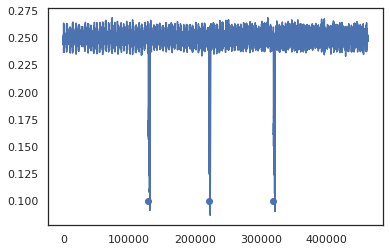

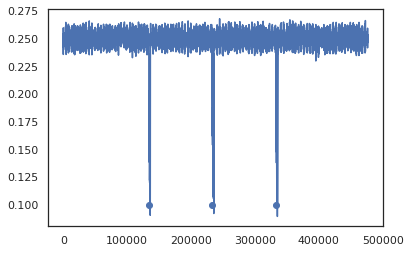

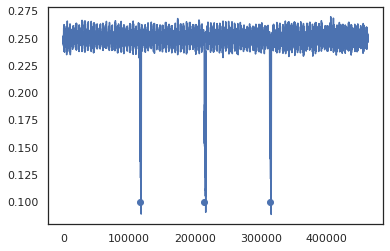

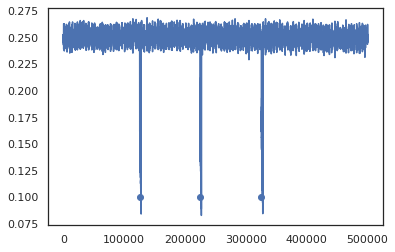

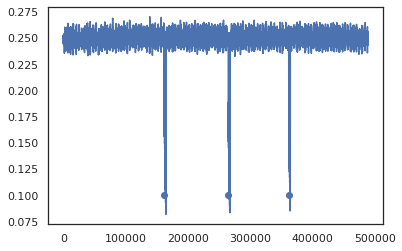

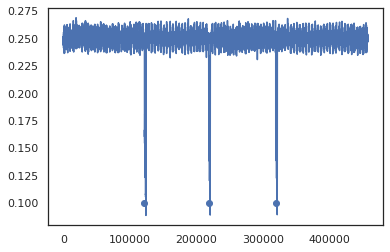

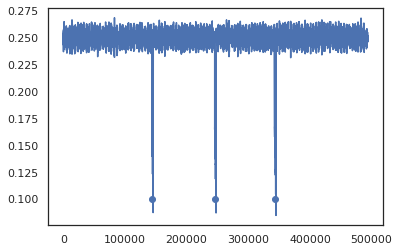

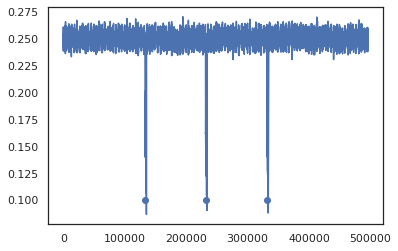

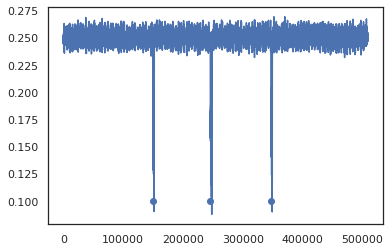

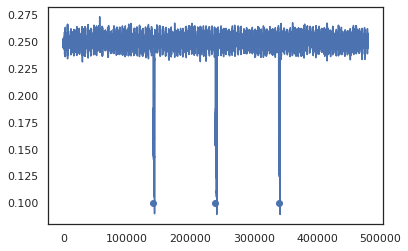

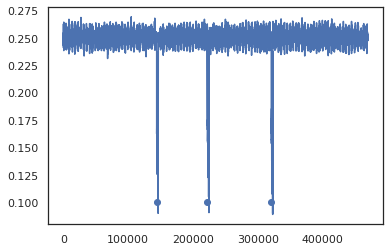

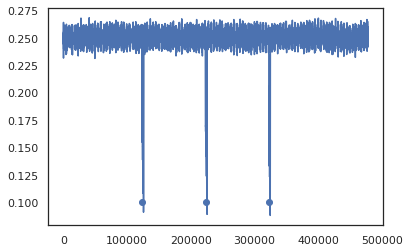

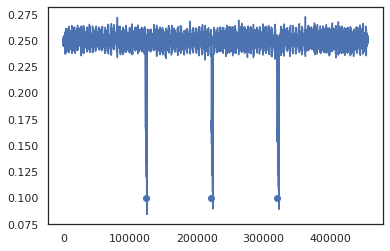

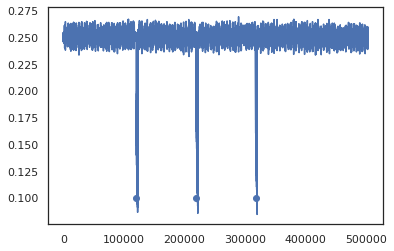

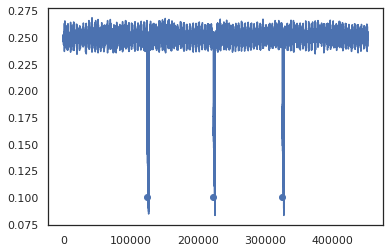

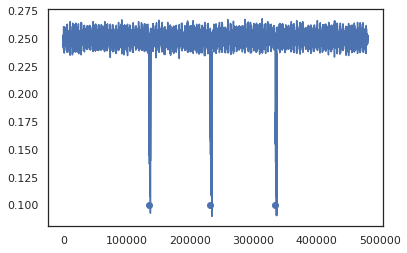

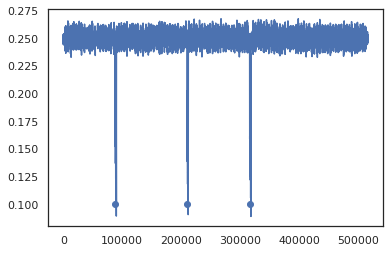

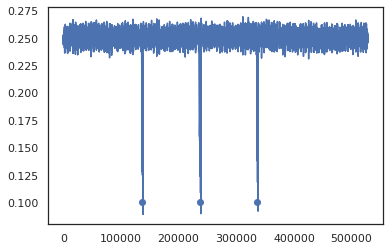

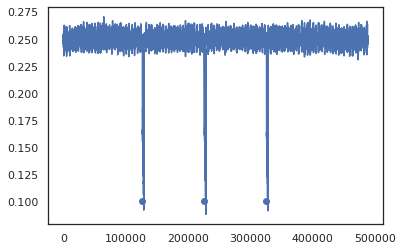

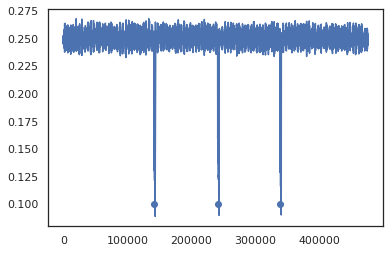

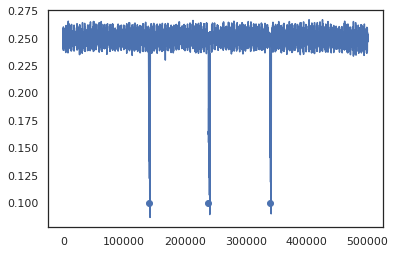

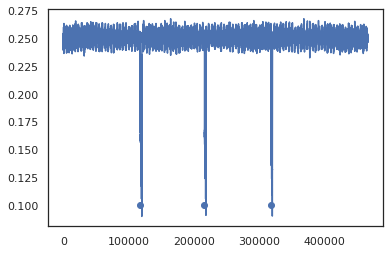

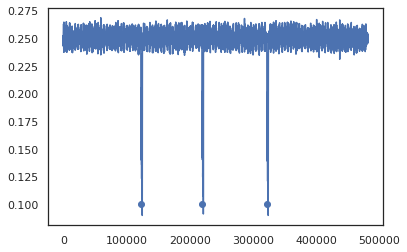

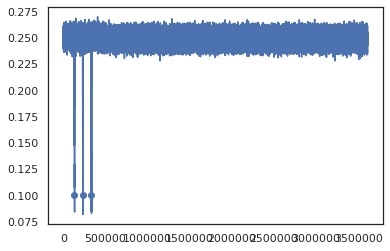

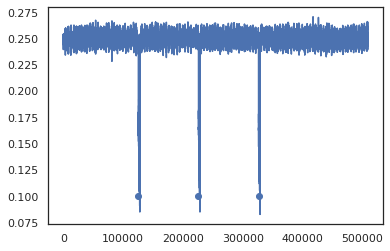

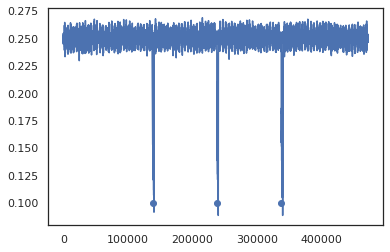

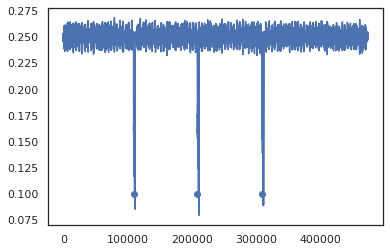

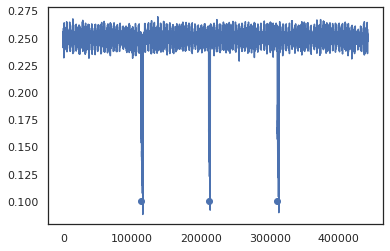

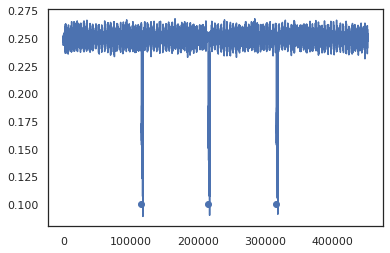

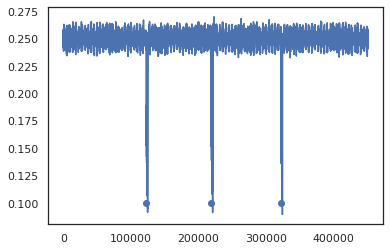

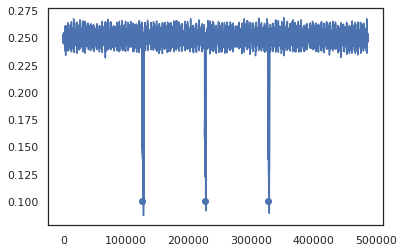

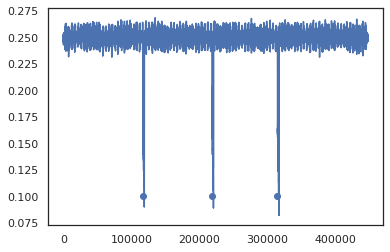

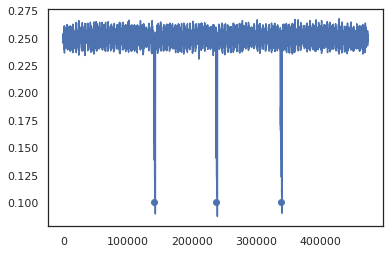

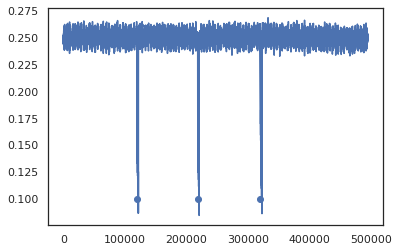

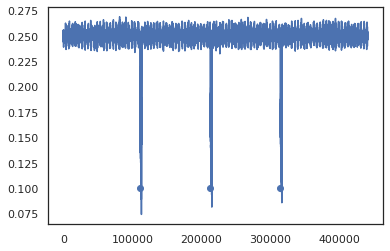

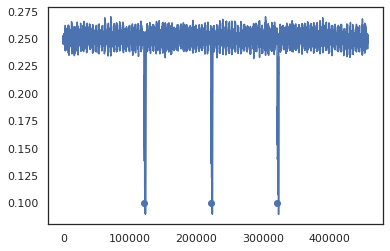

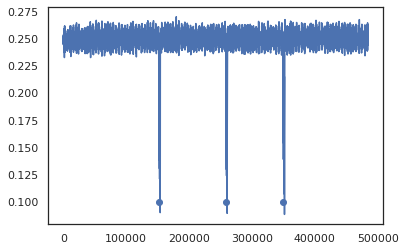

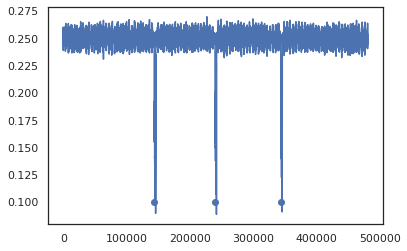

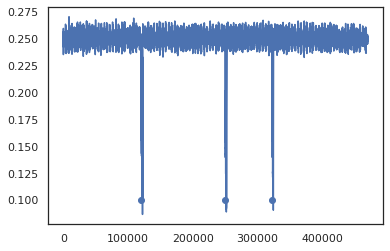

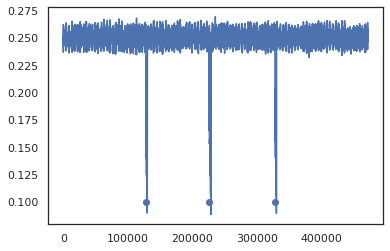

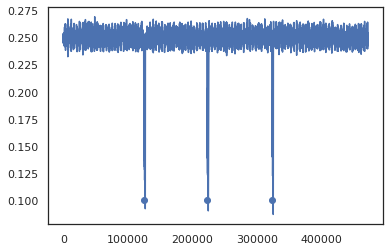

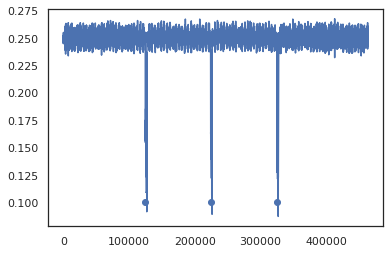

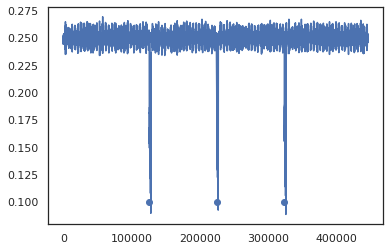

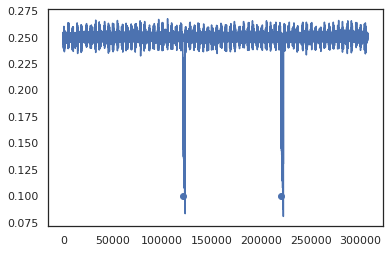

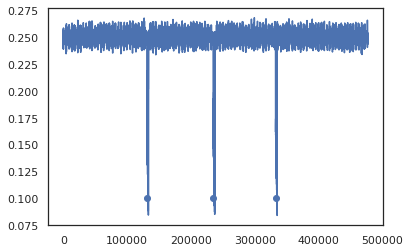

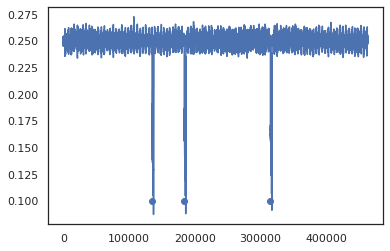

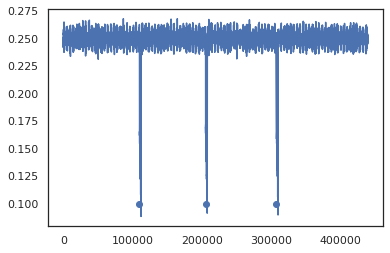

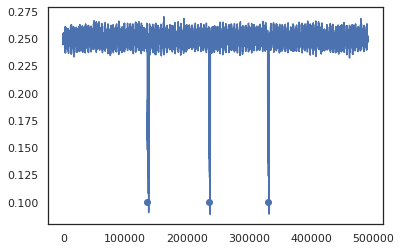

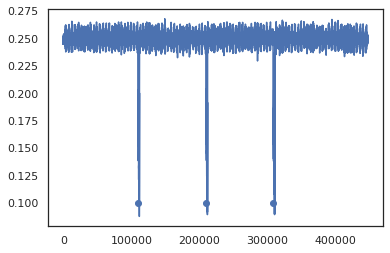

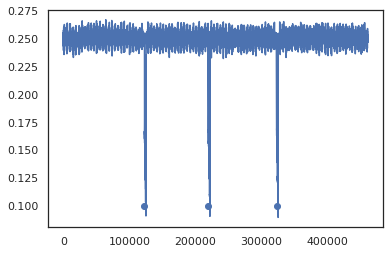

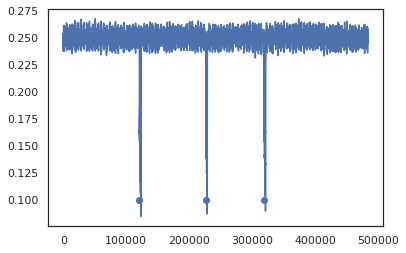

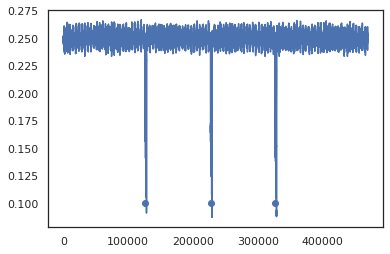

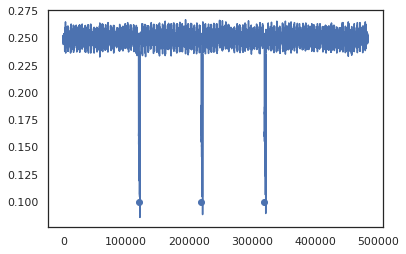

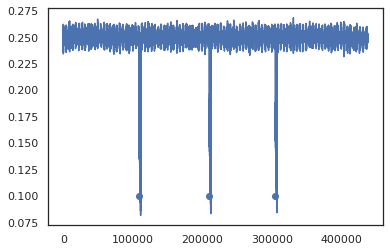

In [13]:
# To do:
# - Find paq and data files in folder and pair them together
# - Find imaging start and crop paq to that start time
# - Find stim times offset for start of imaging
# - Find frames stim occurred on based on 30 Hz frame rate and 10 kHz sampling rate, and 250 ms stim duration (add enough frames to be safe)
# - DONT FORGET 2 CHANNEL IMAGING, SO TAKE EVERY OTHER FRAME FIRST (DEINTERLEAVE)
# - Load tiff
# - Take pixels corresponding to ROI of interest (pixels delineated by .csv from imagej?)
# - Average those pixels across the stack to form 1D trace of cell in that trial
# - STA using frames calculated earlier, pre, post, average
# GET ALL STIMS ASSOCIATED WITH ONE CELL TO PLOT A SINGLE PPSF ACROSS OPSF?

cells_to_analyse = np.arange(60,78)

for cell in cells_to_analyse:
    input_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_3', 'Cell' + str(cell))
    output_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_3', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_list = os.listdir(input_dir)
    file_list.sort()

    for file in file_list:
        if '.paq' in file: 
            
#             if 'Cell10_NA0.73_reverse_00006' in file:
#                 continue
                
            print(file, '.........', end='\r')
            paq = paq_read(os.path.join(input_dir, file))
            
            samples = thresh_signal(paq['data'][0,:], 0.17, direction='less')

            stim_samples = [] 

            for i, sample in enumerate(samples[:-1]):
                if i==0: 
                    stim_samples.append(sample) #don't do calculation on first thresholded sample
                elif sample - samples[i-1] > 5000:
                    stim_samples.append(sample) #include all thresholded samples that are 5000 samples from any other

            if stim_samples[0] == 0: # if first thresholded value is 0, implies trace started low, replace with first value above 0.1
                stim_samples = stim_samples[1:] #remove first value
                samples = thresh_signal(paq['data'][0,:], 0.1, direction='more') #stim can't happen until at least 10 seconds after recording start
                stim_samples[0] = samples[0]
                
            plt.plot(paq['data'][0,:])
            plt.scatter(stim_samples, np.repeat(0.1,len(stim_samples)))
            plt.show();

            imaging_start = thresh_signal(paq['data'][1,:], 1, direction='more')

            stim_start_frames = np.round((stim_samples - imaging_start)/(10000/30))
            stim_dur_frames = np.ceil(250*(1/30))
            
            # check stim start frames are roughly 300, 600, 900
            
#             assert len(stim_start_frames) == 3, 'fewer than 3 stims, should be exactly 3'
            assert stim_start_frames[0] > 50, 'first stim frame too soon (before imaging frame 50)'
            assert np.all(np.diff(stim_start_frames) > 140), 'timing between stims is too close (fewer than 150 frames)'

            file = os.path.splitext(file)[0]
            filters = [file.split('_')[-1]] + ['.tif']
            
            try: 
                
                for f in file_list:
                    if all(s in f for s in filters):
                        cell_stack = ScanImageTiffReader(os.path.join(input_dir, f)).data()
                        cell_stack = cell_stack[0::2]
                        cell_stack[np.where(cell_stack<0)] = 0

                        avg_raw_img = np.mean(cell_stack, axis=0)

                        avg_raw_img = avg_raw_img.astype(np.int16)

                        tf.imwrite(os.path.join(output_dir, file + '_avg_rawGCaMP_image.tif'), avg_raw_img)

                        pre_frames = 45
                        post_frames = 105

                        trial_stack = np.empty([0, pre_frames+post_frames, 512, 512]).astype(np.int16)

                        for stim in np.array(stim_start_frames, dtype='int'):
                            if stim > 46:
                                trial_frames = np.s_[stim-pre_frames : stim+post_frames]
                            else:
                                trial_frames = np.s_[0 : stim+post_frames]

                            trial = cell_stack[trial_frames]
                            trial = np.expand_dims(trial,axis=0)

                            trial_stack = np.append(trial_stack, trial, axis=0)

                        avg_movie = trial_stack.mean(axis=0).astype(np.int16)                
                        tf.imwrite(os.path.join(output_dir, file + '_STA.tif'), avg_movie)

                        gc.collect()
                        
            except: 
                    
                print('could not complete stim processing for cell' + str(cell))
    #                 baseline = avg_movie[range(pre_frames), ...].mean(axis=0)
    #                 norm_movie = ((avg_movie - baseline) / baseline) 
    #                 norm_movie = sta.remove_inf_nan(norm_movie)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA.tif'), norm_movie.astype(np.int32))

    #                 avg_img_frames = range(60, 120)                
    #                 avg_img_dff = sta.make_avg_image(norm_movie, avg_img_frames).astype(np.int16)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA_avgImg.tif'), avg_img_dff)

(200000, 220000)

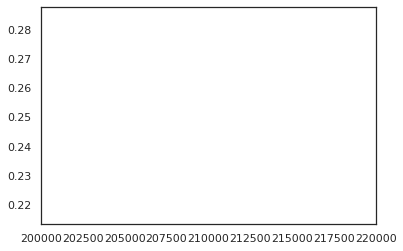

In [12]:
plt.plot(paq['data'][0,:])
plt.scatter(stim_samples, np.repeat(0.1,len(stim_samples)))
plt.xlim([200000,220000])

### Cells with multiple NA tests

In [ ]:
cells_to_analyse = np.arange(1,7)

for cell in cells_to_analyse:
    input_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data', 'Cell' + str(cell), 'Imagej_output')
    output_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_list = os.listdir(input_dir)
    file_list.sort()

    for f in file_list:
        if '.zip' in f:
            rois = read_roi_zip(os.path.join(input_dir, f))
            roi_names = [key for key in rois.keys()]

    i = 0
    traces = np.empty([len(roi_names), 150])
    
    for f in file_list:
        if '.tif' in f:
            print('Loading', f, '........', end='\r')
            dff_stack = tf.imread(os.path.join(input_dir, f))

            x_roi = rois[roi_names[i]]['x']
            y_roi = rois[roi_names[i]]['y']

            x, y = np.meshgrid(np.arange(512), np.arange(512)) # make a canvas with coordinates
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T 

            coords = list(zip(x_roi,y_roi))
            p = Path(coords) # make a polygon
            grid = p.contains_points(points)
            mask = grid.reshape(512,512) # now you have a mask with points inside a polygon

            cell_coords = np.where(mask)
            
            dff_stack = sta.remove_inf_nan(dff_stack)
            trace = np.nanmean(dff_stack[:, cell_coords[0], cell_coords[1]], axis=1)
            traces[i] = trace
            
            i += 1
            
    x = [-425, -350, -250, -150, -50, 0, 50, 150, 250, 380]
    plt.plot(x, traces[:10, 50:120].mean(axis=1), label='NA 0.3')
    plt.plot(x, traces[10:20, 50:120].mean(axis=1), label='NA 0.5')
    plt.plot(x, traces[20:30, 50:120].mean(axis=1), label='NA 0.73')

    plt.legend();
    plt.show();

### Universal processing for single cells PPSF vs. OPSF data (single trial)

In [3]:
# To do:
# - Find paq and data files in folder and pair them together
# - Find imaging start and crop paq to that start time
# - Find stim times offset for start of imaging
# - Find frames stim occurred on based on 30 Hz frame rate and 10 kHz sampling rate, and 250 ms stim duration (add enough frames to be safe)
# - DONT FORGET 2 CHANNEL IMAGING, SO TAKE EVERY OTHER FRAME FIRST (DEINTERLEAVE)
# - Load tiff
# - Take pixels corresponding to ROI of interest (pixels delineated by .csv from imagej?)
# - Average those pixels across the stack to form 1D trace of cell in that trial
# - STA using frames calculated earlier, pre, post, average
# GET ALL STIMS ASSOCIATED WITH ONE CELL TO PLOT A SINGLE PPSF ACROSS OPSF?

cells_to_analyse = np.arange(30,52)

for cell in cells_to_analyse:
    input_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_3', 'Cell' + str(cell))
    output_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_3', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_list = os.listdir(input_dir)
    file_list.sort()

    for file in file_list:
        if '.paq' in file:

            print(file, '.........', end='\r')
            paq = paq_read(os.path.join(input_dir, file))

            samples = thresh_signal(paq['data'][0,:], 0.22, direction='less')
            stim_samples = [sample for i, sample in enumerate(samples[:-1]) if (samples[i+1] - sample) > 1000]
            stim_samples = np.array(stim_samples[0::2])
            
            imaging_start = thresh_signal(paq['data'][1,:], 1, direction='more')

            stim_start_frames = np.round((stim_samples - imaging_start)/(10000/30))
            stim_dur_frames = np.ceil(250*(1/30))
            
            # check stim start frames are roughly 300, 600, 900
            
            assert len(stim_start_frames) == 3, 'fewer than 3 stims, should be exactly 3'
            assert stim_start_frames[0] > 50, 'first stim frame too soon (before imaging frame 50)'
            assert np.all(np.diff(stim_start_frames) > 150), 'timing between stims is too close (fewer than 150 frames)'

            file = os.path.splitext(file)[0]
            filters = file.split('_')[1:] + ['.tif']
            
            try: 
                
                for f in file_list:
                    if all(s in f for s in filters):
                        cell_stack = ScanImageTiffReader(os.path.join(input_dir, f)).data()
                        cell_stack = cell_stack[0::2]
                        cell_stack[np.where(cell_stack<0)] = 0

                        avg_raw_img = np.mean(cell_stack, axis=0)

                        avg_raw_img = avg_raw_img.astype(np.int16)
                        
                        pre_frames = 45
                        post_frames = 105

                        trial_stack = np.empty([0, pre_frames+post_frames, 512, 512]).astype(np.int16)

                        for stim in np.array(stim_start_frames, dtype='int'):
                            if stim > 46:
                                trial_frames = np.s_[stim-pre_frames : stim+post_frames]
                            else:
                                trial_frames = np.s_[0 : stim+post_frames]

                            trial = cell_stack[trial_frames]
                            trial = np.expand_dims(trial,axis=0)

                            trial_stack = np.append(trial_stack, trial, axis=0)
                        
                        avg_movie = trial_stack.mean(axis=0).astype(np.int16)             
                        tf.imwrite(os.path.join(output_dir, file + '_STA.tif'), avg_movie)

                        gc.collect()
                        
            except: 
                    
                print('could not complete stim processing for cell' + str(cell))
    #                 baseline = avg_movie[range(pre_frames), ...].mean(axis=0)
    #                 norm_movie = ((avg_movie - baseline) / baseline) 
    #                 norm_movie = sta.remove_inf_nan(norm_movie)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA.tif'), norm_movie.astype(np.int32))

    #                 avg_img_frames = range(60, 120)                
    #                 avg_img_dff = sta.make_avg_image(norm_movie, avg_img_frames).astype(np.int16)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA_avgImg.tif'), avg_img_dff)

AssertionError: first stim frame too soon (before imaging frame 50)

### Cells with single NA test

In [408]:
cells_to_analyse = np.arange(1,78)

all_traces = np.full([len(cells_to_analyse), 10, 150], np.nan)
all_na = np.empty([len(cells_to_analyse)], dtype=object)
all_directions = np.empty([len(cells_to_analyse)], dtype=object)

for cell_i, cell in enumerate(cells_to_analyse):
    roi_dir = os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'Cell' + str(cell), 'Imagej_output')
    input_dir = os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'Cell' + str(cell), 'Imagej_output')
    output_dir = os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    file_list = os.listdir(input_dir)
    file_list.sort()

    roi_file_list = os.listdir(roi_dir)
    roi_file_list.sort()
    
    for f in roi_file_list:
#         if '.zip' in f:
#             rois = read_roi_zip(os.path.join(roi_dir, f))
#             roi_names = [key for key in rois.keys()]
            if '.roi' in f:
                roi = read_roi_file(os.path.join(roi_dir, f))
                (roi_key,roi_value), = roi.items()
    
#     assert len(roi_names) == 10, 'fewer than 10 ROIs'
    
    if len(file_list) > 0:
        if 'reverse' in file_list[0]:    
            pos_i = 9
            all_directions[cell_i] = 'reverse'
        else: 
            pos_i = 0
            all_directions[cell_i] = 'standard'
    
    for f in file_list:
        if 'dff.tif' in f:
            if pos_i is not 5: # eliminating position 0 as it is not evenly spaced from -50/+50
                print('Loading', f, '........', end='\r')
                na = f.split('_')[5]
                dff_stack = tf.imread(os.path.join(input_dir, f))

#                 x_roi = np.array(rois[roi_names[pos_i]]['x']) 
#                 y_roi = np.array(rois[roi_names[pos_i]]['y']) 
#                 x_roi = np.array(roi_value['x'])  
#                 y_roi = np.array(roi_value['y']) 
                x_roi = np.array(roi_value['x']) - 100 
                y_roi = np.array(roi_value['y']) - 100
        
                x, y = np.meshgrid(np.arange(512), np.arange(512)) # make a canvas with coordinates
                x, y = x.flatten(), y.flatten()
                points = np.vstack((x,y)).T 

                coords = list(zip(x_roi,y_roi))
                p = Path(coords) # make a polygon
                grid = p.contains_points(points)
                mask = grid.reshape(512,512) # now you have a mask with points inside a polygon

                cell_coords = np.where(mask)

                dff_stack = sta.remove_inf_nan(dff_stack)
                trace = np.nanmean(dff_stack[:, cell_coords[0], cell_coords[1]], axis=1)
                all_traces[cell_i, pos_i] = trace
                
                if 'NA' in f.split('_')[5]:
                    all_na[cell_i] = f.split('_')[5]
                else: 
                    all_na[cell_i] = f.split('_')[3]                
            
            if len(file_list) > 0:
                if 'reverse' in file_list[0]:
                    pos_i -= 1
                else:
                    pos_i += 1
    
np.save(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_curves_control.npy'), all_traces)
np.save(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF',  'Axial_res_PPSF_data_3', 'resolution_na_control.npy'), all_na)
np.save(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_directions_control.npy'), all_directions)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


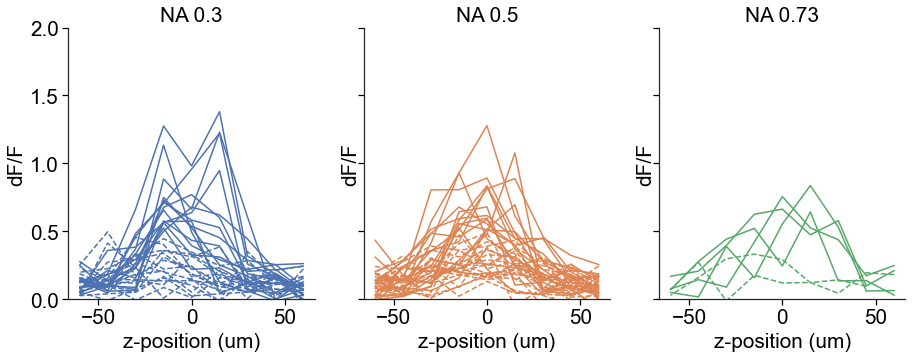

In [173]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_curves_corrected.npy'))
all_na = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_na_corrected.npy'), allow_pickle=True)

low_na = np.where(all_na == 'NA0.3')[0]
mid_na = np.where(all_na == 'NA0.5')[0]
high_na = np.where(all_na == 'NA0.73')[0]

pos_i = [0, 1, 2, 3, 4, 6, 7, 8, 9]
all_traces = all_traces[:, pos_i, :]

position_um = np.array([60, 45, 30, 15, 0, -15, -30, -45, -60])

color = ['C0', 'C1', 'C2']
nas = ['NA 0.3', 'NA 0.5', 'NA 0.73']

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))

for na_i, na in enumerate([low_na, mid_na, high_na]):
    
    na_positions = np.nanmean(all_traces[na, :, 55:100], axis=2)
    responders = np.unique(np.where(na_positions>0.5)[0])
#     na_positions = na_positions[responders]
    
    # fig, axes = plt.subplots(nrows=na_positions.shape[0], ncols=1, sharex=True, sharey=True, figsize=(2,11))

    # for i, (ax, na, cell) in enumerate(zip(fig.axes, all_na, na_positions)):
    #     ax.plot(position_um, na_positions[i], 'y', label=na);
    #     ax.set_ylabel('dF/F')
    
    for i, response in enumerate(na_positions):
        if i in responders:
            ls = 'solid'
        else: 
            ls = 'dashed'
            
        axes[na_i].plot(position_um, response,  color=color[na_i], linestyle=ls);
        axes[na_i].set_ylabel('dF/F');
        axes[na_i].set_xlabel('z-position (um)');
        axes[na_i].set_title(nas[na_i])
        axes[na_i].set_ylim([0, 2])

# save_path = os.path.join(qnap_path, 'Analysis',  'OPSF_vs_PPSF', '3mW_allCells')
# plt.savefig(save_path + '.png', bbox_inches='tight')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

### FWHM calculations 

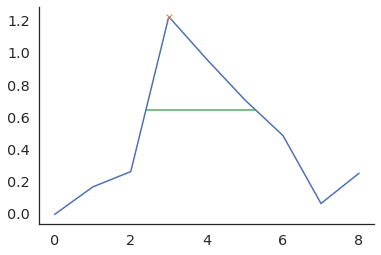

[2.88961186]


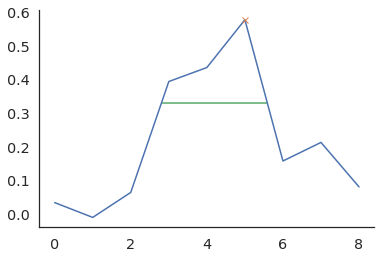

[2.78816081]


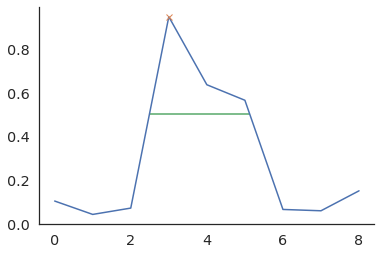

[2.63059571]


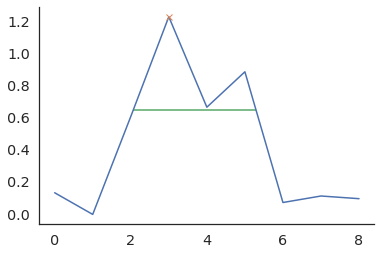

[3.22003245]


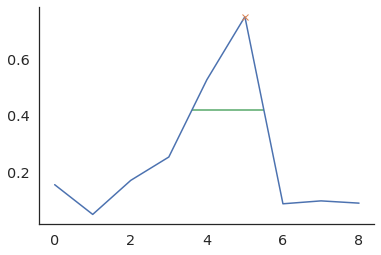

[1.89483622]


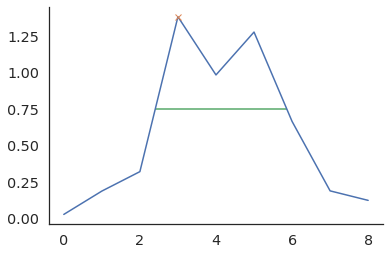

[3.44909858]


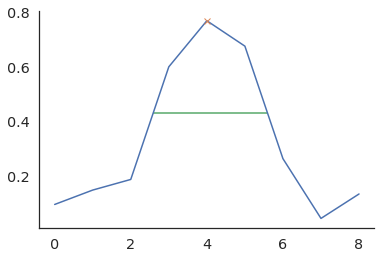

[2.99714527]


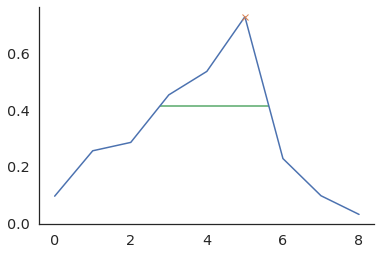

[2.8762647]


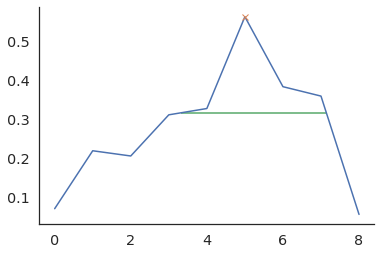

[3.80682623]


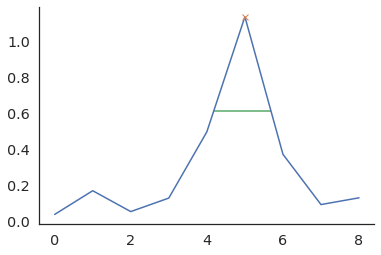

[1.49882851]


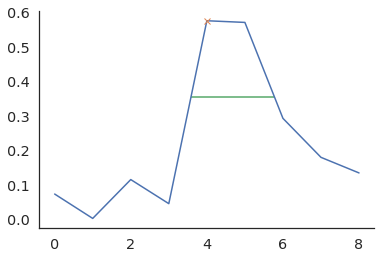

[2.19185691]


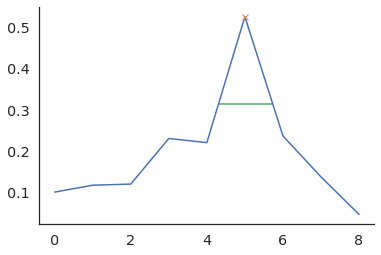

[1.43229032]


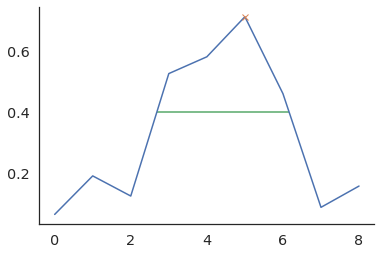

[3.4758485]


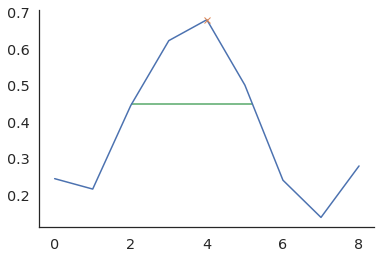

[3.18572591]


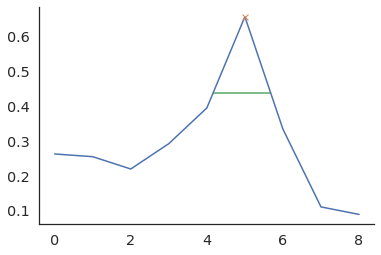

[1.51190033]


In [3]:
from scipy.signal import chirp, find_peaks, peak_widths

na_positions = np.nanmean(all_traces[low_na, :, 55:100], axis=2)
responders = np.unique(np.where(na_positions>0.5)[0])

x = np.array([60, 45, 30, 15, 0, -15, -30, -45, -60])

for cell in responders:
    y = na_positions[cell]

    # plt.plot(x, y, 'o', xnew, f(xnew), '--')

    peaks, _ = find_peaks(y, height=(np.amax(y)))
    results_half = peak_widths(y, peaks, rel_height=0.5)
    plt.plot(y)
    plt.plot(peaks, y[peaks], "x")
    plt.hlines(*results_half[1:], color="C2")
    plt.show()
    fwhm = results_half[0]
    print(fwhm)

### Gaussian fit

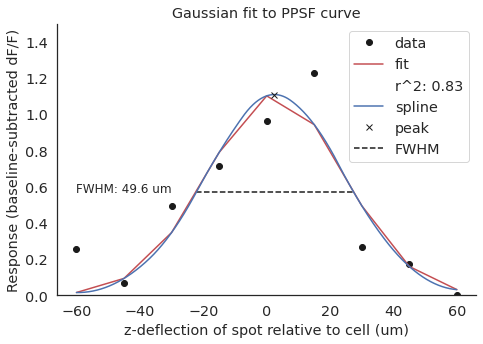

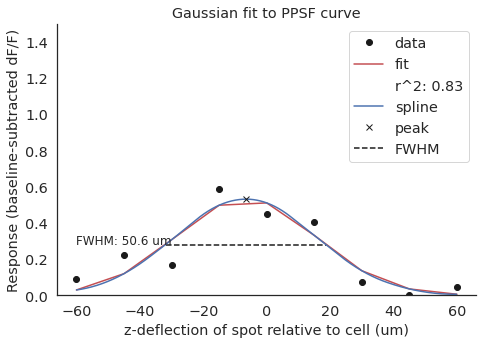

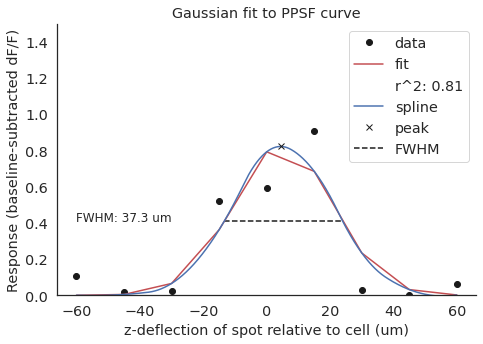

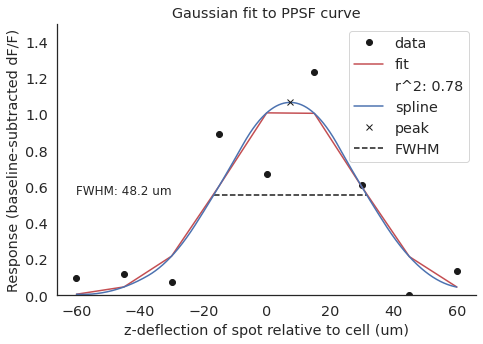

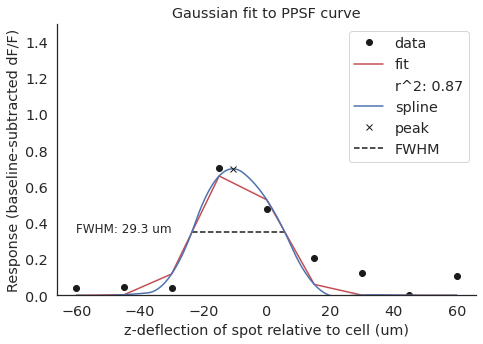

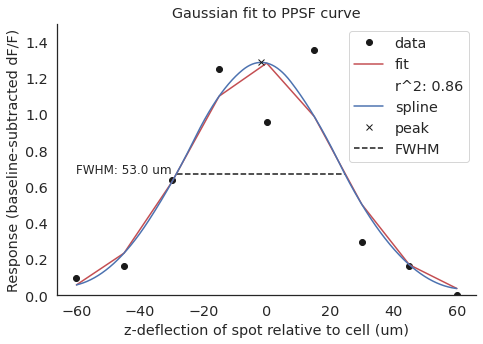

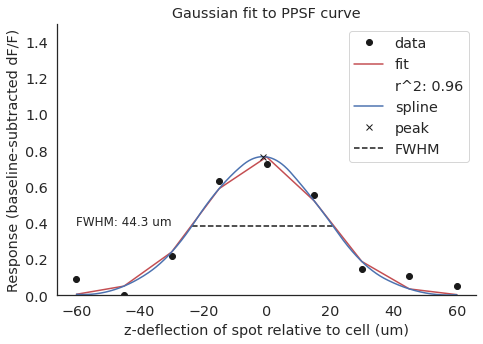

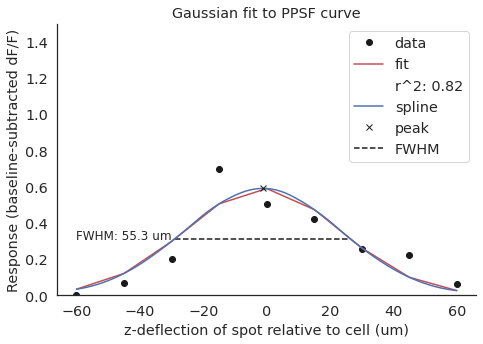

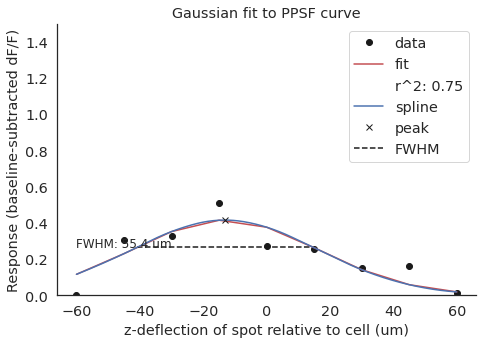

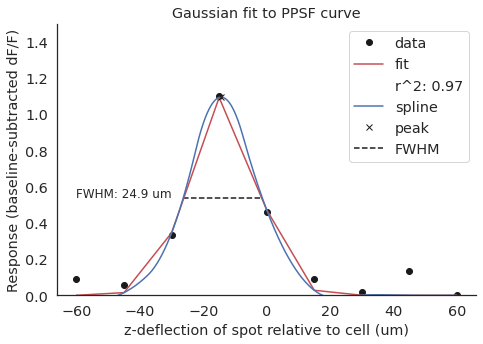

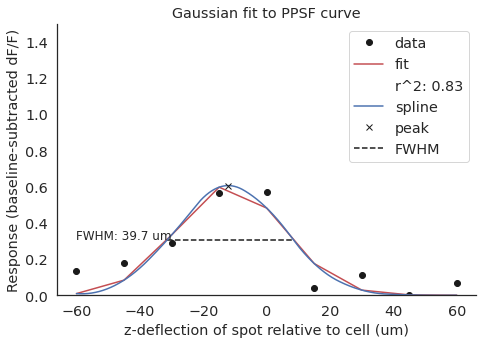

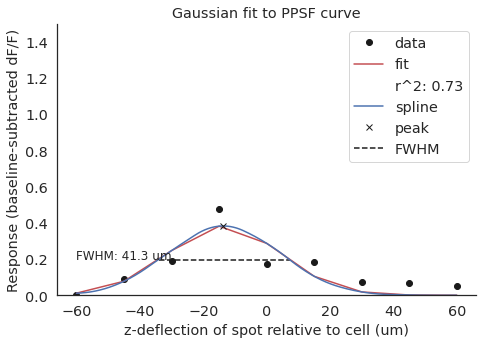

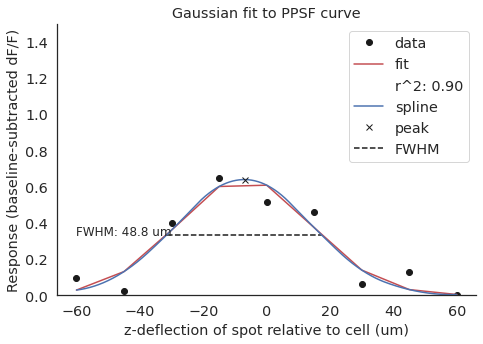

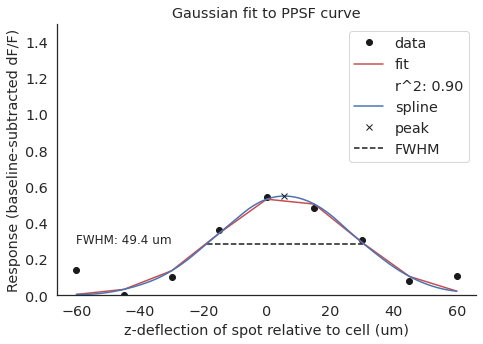

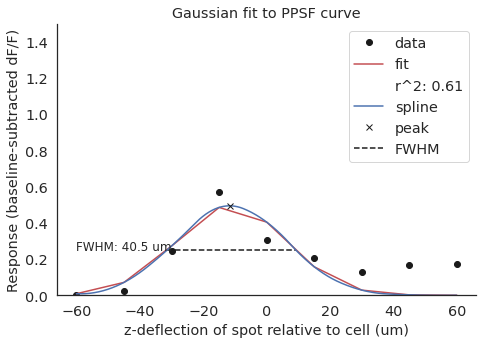

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


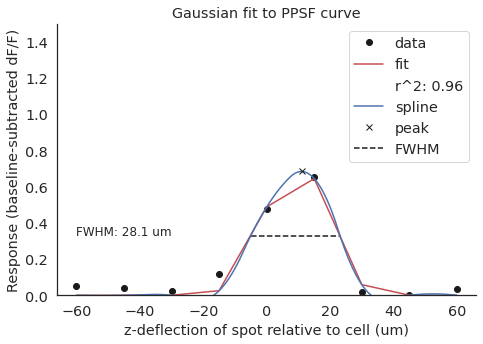

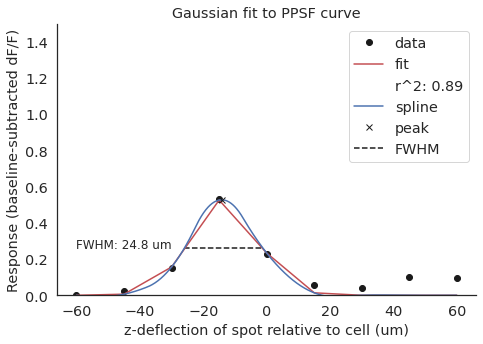

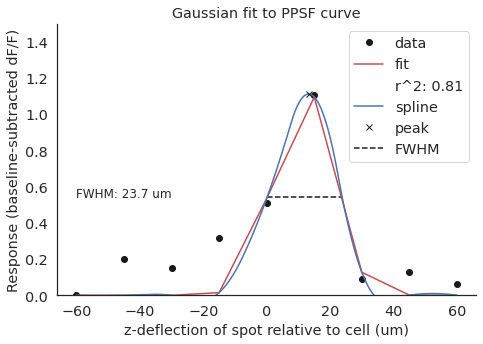

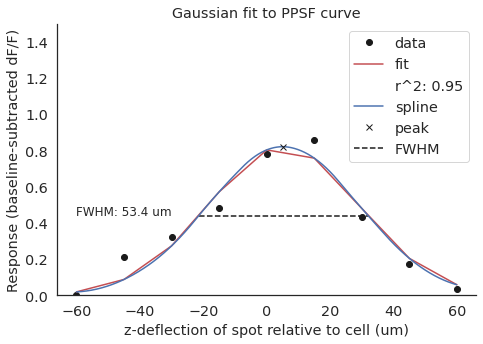

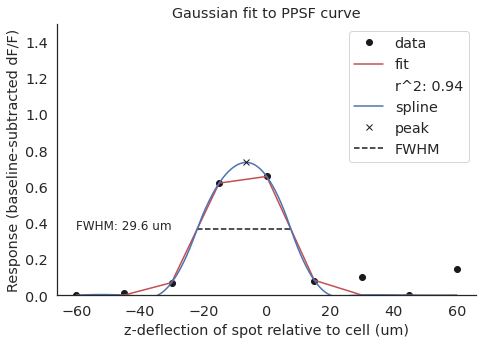

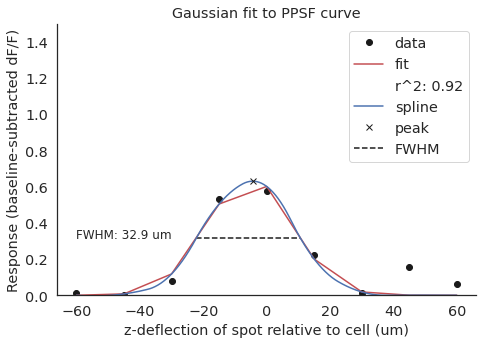

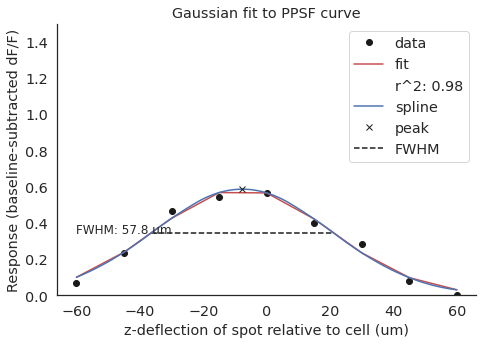

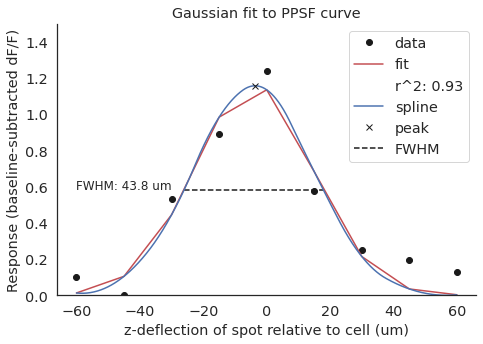

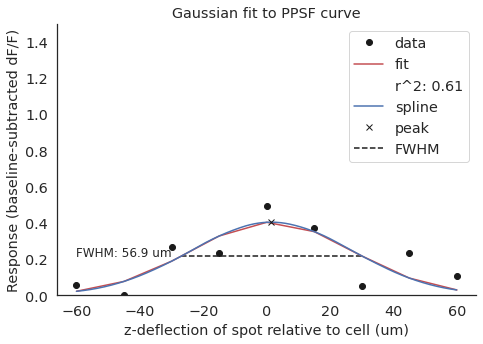

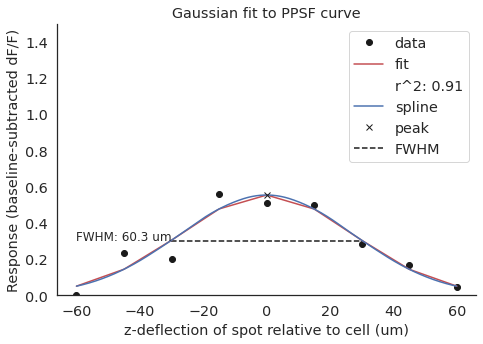

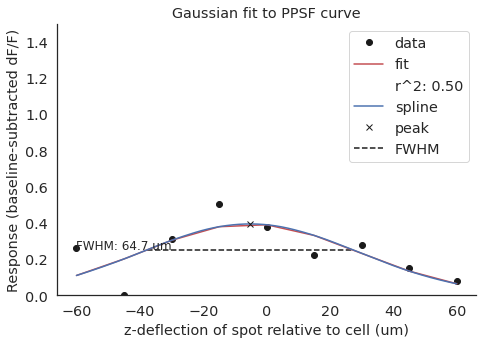

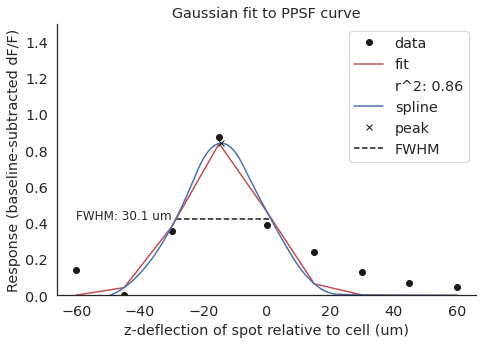

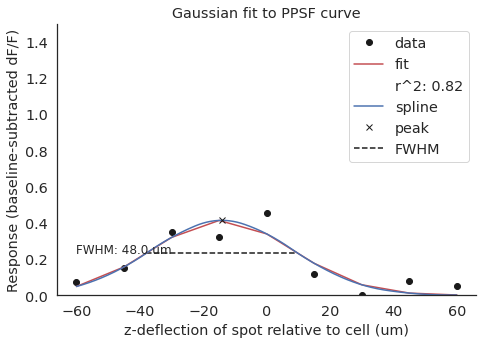

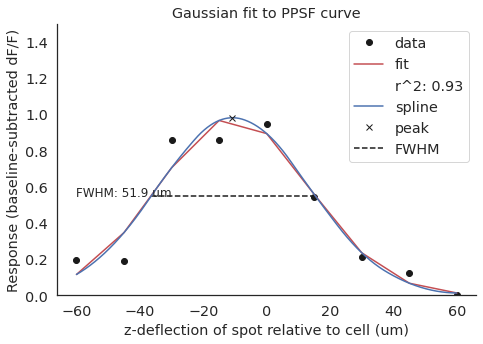

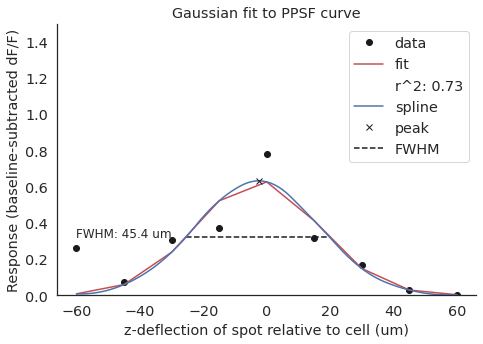

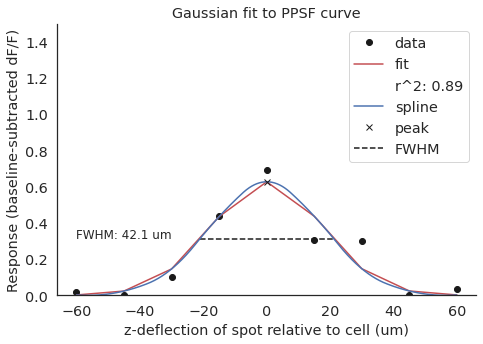

In [4]:
# Fit gaussian to curve

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

all_max_dff = []
all_fwhm = []
all_na = []

nas = ['NA0.3', 'NA0.5']

for i,res in enumerate([low_na, mid_na]):
    
    na_positions = np.nanmean(all_traces[res, :, 55:100], axis=2)
    responders = np.unique(np.where(na_positions>0.5)[0])

    x = np.array([60, 45, 30, 15, 0, -15, -30, -45, -60])

    for cell in responders:
        y = na_positions[cell]

        # subtract baseline from data
        min_y = np.nanmin(y)
        y = y-min_y

        # guess parameters for gaussian
        n = len(x)                            #the number of data
        mean = sum(x*y)/sum(y)                #note this correction
        sigma = np.sqrt(sum(y*(x-mean)**2)/n) #note this correction

        # gaussian function
        def gaus(x,a,x0,sigma):
            return a*exp(-(x-x0)**2/(2*sigma**2))

        # curve fitting gaussian to data
        popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
        # popt = peak y, position of centre of peak on x and standard deviation on x

        # plot raw data and gaussian fit (linear)
        plt.figure(figsize=(7.5,5))
        plt.plot(x,y,'ko',label='data')
        plt.plot(x,gaus(x,*popt),'r',label='fit')
        plt.legend()
        plt.title('Gaussian fit to PPSF curve')
        plt.xlabel('z-deflection of spot relative to cell (um)')
        plt.ylabel('Response (baseline-subtracted dF/F)')

        # calculate r^2 for gaussian fit
        residuals = y - gaus(x, *popt)
        ss_res = np.sum(residuals**2)

        ss_tot = np.sum((y-np.mean(y))**2)

        r_squared = 1 - (ss_res / ss_tot)

        plt.plot([], [], ' ', label='r^2:' + f'{r_squared:5.2f}')

        # spline interpolation of gaussian curve
        y_gaus = gaus(x,*popt)

        f_spline = interpolate.interp1d(x, y_gaus, kind='quadratic')

        xnew = np.arange(-60, 60, 0.1)
        ynew = f_spline(xnew)

        # fwhm of interpolated curve
        peaks, _ = find_peaks(ynew, height=(np.amax(y_gaus)))
        results_half = peak_widths(ynew, peaks, rel_height=0.5)
        plt.plot(xnew, ynew, 'b', label='spline')
        plt.plot(xnew[peaks], ynew[peaks], "kx", label='peak')

        y_fwhm = results_half[1]
        xmin_fwhm = xnew[np.round(results_half[2]).astype('int')]
        xmax_fwhm = xnew[np.round(results_half[3]).astype('int')]
        plt.hlines(y_fwhm, xmin_fwhm, xmax_fwhm, linestyle='dashed', color='k', label='FWHM')

        fwhm = results_half[0]
        plt.text(-60, results_half[1], 'FWHM:' + f'{fwhm[0]*0.1:5.1f}' + ' um')
        plt.legend(loc='upper right')
        plt.ylim([0, 1.5])
        plt.show()

        all_max_dff.append(ynew[peaks])
        all_fwhm.append(fwhm[0]*0.1)
        all_na.append(nas[i])

    # save_path = os.path.join(qnap_path, 'Analysis',  'OPSF_vs_PPSF', 'example_gaus_6mW_fwhm_singleCell')
    # plt.savefig(save_path + '.png', bbox_inches='tight')
    # plt.savefig(save_path + '.svg', bbox_inches='tight')

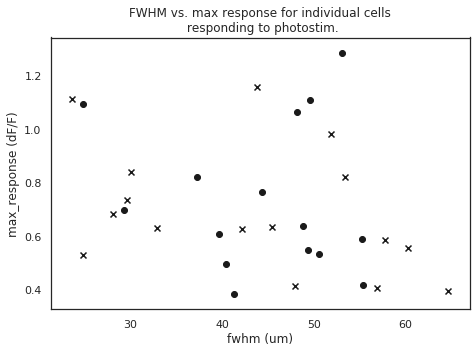

In [71]:
nas = ['NA0.3', 'NA0.5']
plot_marker = ['o', 'x']

all_na = np.array(all_na, dtype='object')
all_fwhm = np.array(all_fwhm)
all_max_dff = np.array(all_max_dff)

plt.figure(figsize=(7.5,5))

for i, na in enumerate(nas):
    cell_i = np.where(all_na==na)[0]
    plt.scatter(all_fwhm[cell_i], all_max_dff[cell_i], color='k', marker=plot_marker[i], label=na)
    plt.xlabel('fwhm (um)')
    plt.ylabel('max_response (dF/F)')
    plt.title('FWHM vs. max response for individual cells\n responding to photostim.')
#     plt.legend()
    
# save_path = os.path.join(qnap_path, 'Analysis',  'OPSF_vs_PPSF', 'fwhm_vs_maxdFF_3mW')
# plt.savefig(save_path + '.png', bbox_inches='tight')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/rlees/Documents/Code/PPSF_vs_OPSF/utils/utils_funcs_ppsf_vs_opsf.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr, axis)
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/rlees/Documents/Code/PPSF_vs_OPSF/utils/utils_funcs_ppsf_vs_opsf.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr, axis)
/home/rlees/anaconda3/envs/s

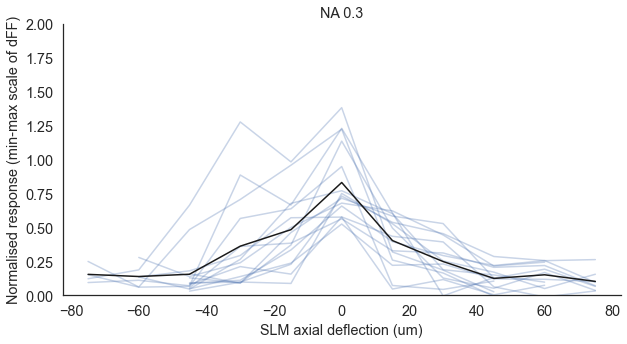

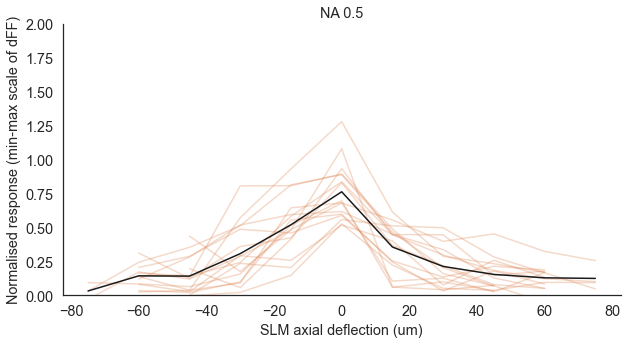

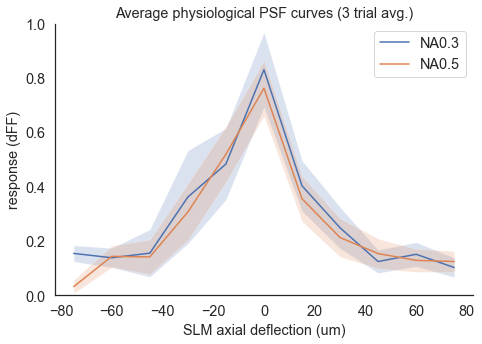

In [22]:
from sklearn.preprocessing import minmax_scale

all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_curves_corrected.npy'))
all_na = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_3', 'resolution_na_corrected.npy'), allow_pickle=True)

pos_i = [0, 1, 2, 3, 4, 6, 7, 8, 9]
all_traces = all_traces[:, pos_i, :]
x = np.arange(135, -150, -15)
# x = np.arange(60, -61, -15)

low_na = np.where(all_na == 'NA0.3')[0]
mid_na = np.where(all_na == 'NA0.5')[0]
high_na = np.where(all_na == 'NA0.73')[0]

all_mean_curves = []
all_error_curves = []
color = ['C0', 'C1', 'C2']
nas = ['NA 0.3', 'NA 0.5', 'NA 0.73']

for na_i, na in enumerate([low_na, mid_na]):
    
    plt.figure(figsize=(10,5));
    
    na_positions = np.nanmean(all_traces[na, :, 55:100], axis=2)
    responders = np.unique(np.where(na_positions>0.5)[0])
    na_positions = na_positions[responders]
#     na_positions = np.delete(na_positions, responders, 0)

#     for position_i, cell in enumerate(na_positions):
#         na_positions[position_i] = minmax_scale(cell, axis=0)
#         na_positions[position_i] = cell/np.nanmax(cell)

    na_positions = np.pad(na_positions, ((0,0), (5,5)), 'constant', constant_values=(np.nan, np.nan))
    m,n = na_positions.shape
    row_shifts = n//2 - np.nanargmax(na_positions, axis=1)
    col_idx = np.mod(np.arange(n)[:, None]-row_shifts,n)
    col_idx = col_idx.T

    for position_i,(cell,col_i) in enumerate(zip(na_positions, col_idx)):
        na_positions[position_i] = cell[col_i]

    plt.plot(x, na_positions.T, color=color[na_i], alpha=0.3);
    
    mean_curve = np.nanmean(na_positions, axis=0)
    plt.plot(x, mean_curve, 'k');
    plt.xlabel('SLM axial deflection (um)')
    plt.ylabel('Normalised response (min-max scale of dFF)')
    plt.title(nas[na_i])
    plt.ylim([0, 2])
    
    all_mean_curves.append(mean_curve)
    
    mean, std, ci, sem = meanError(na_positions, axis=0)
    all_error_curves.append(ci)

mean_curves = np.array(all_mean_curves)
error_curves = np.array(all_error_curves)
plt.figure(figsize=(7.5,5))

for y, err in zip(mean_curves, error_curves):
    plt.plot(x, y.T);
    plt.fill_between(x, y + err, y - err, alpha=0.2, zorder=1);
    plt.legend(['NA0.3', 'NA0.5'])
    plt.xlabel('SLM axial deflection (um)')
    plt.ylabel('response (dFF)')
    plt.title('Average physiological PSF curves (3 trial avg.)');
    plt.ylim([0, 1])

# save_path = os.path.join(qnap_path, 'Analysis',  'OPSF_vs_PPSF', '3mW_average')
# plt.savefig(save_path + '.png', bbox_inches='tight')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

### Gaussian fit

In [10]:
x = x[4:15]
y = y[4:15]

min_y = np.nanmin(y)
y = y-min_y

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  # This is added back by InteractiveShellApp.init_path()
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  # This is added back by InteractiveShellApp.init_path()


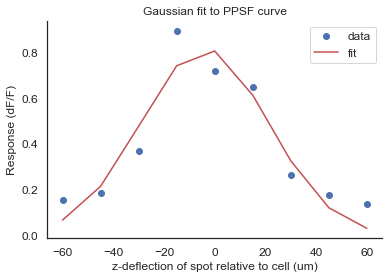

In [20]:
# Fit gaussian to curve

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.plot(x,y,'bo',label='data')
plt.plot(x,gaus(x,*popt),'r',label='fit')
plt.legend()
plt.title('Gaussian fit to PPSF curve')
plt.xlabel('z-deflection of spot relative to cell (um)')
plt.ylabel('Response (dF/F)')
plt.show()

### FWHM calculations

Text(4.7, [0.30491863], 'FWHM: 30.9 um')

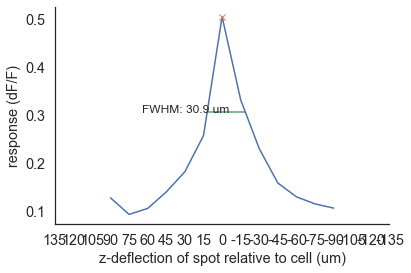

In [21]:
peaks, _ = find_peaks(y, height=(np.nanmax(y)))
results_half = peak_widths(y, peaks, rel_height=0.5)

plt.plot(y)
plt.plot(peaks, y[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.ylabel('response (dF/F)')
plt.xticks(np.arange(len(x)), x)
# plt.xlim([4, 14])
plt.xlabel('z-deflection of spot relative to cell (um)')

fwhm = results_half[0]
plt.text(4.7, results_half[1], 'FWHM:' + f'{fwhm[0]*15:5.1f}' + ' um')

# save_path = os.path.join(qnap_path, 'Analysis',  'OPSF_vs_PPSF', 'FWHM_6mw_NA0.3')
# plt.savefig(save_path + '.png', bbox_inches='tight')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

In [7]:
# Make folders

cells_to_analyse = np.arange(36,60)

for cell in cells_to_analyse:
    output_dir = os.path.join(qnap_path, 'SlowFast_spirals_data', 'Cell' + str(cell))
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
# Move files?

parent_dir = os.path.join(qnap_path, 'SlowFast_spirals_data')

file_list = os.listdir(parent_dir)
file_list.sort()

for file in file_list:
    if any(s in file for s in ['.tif', '.paq']):
        cell_num = file.split('_')[4]
        os.rename(os.path.join(parent_dir, file), os.path.join(parent_dir, cell_num, file))

### Processing for slow/fast spirals

In [72]:
# To do:
# - Find paq and data files in folder and pair them together
# - Find imaging start and crop paq to that start time
# - Find stim times offset for start of imaging
# - Find frames stim occurred on based on 30 Hz frame rate and 10 kHz sampling rate, and 250 ms stim duration (add enough frames to be safe)
# - DONT FORGET 2 CHANNEL IMAGING, SO TAKE EVERY OTHER FRAME FIRST (DEINTERLEAVE)
# - Load tiff
# - Take pixels corresponding to ROI of interest (pixels delineated by .csv from imagej?)
# - Average those pixels across the stack to form 1D trace of cell in that trial
# - STA using frames calculated earlier, pre, post, average
# GET ALL STIMS ASSOCIATED WITH ONE CELL TO PLOT A SINGLE PPSF ACROSS OPSF?

cells_to_analyse = np.arange(40,42)

for cell in cells_to_analyse:
    input_dir = os.path.join(qnap_path, 'SlowFast_spirals_data', 'Cell' + str(cell))
    output_dir = os.path.join(qnap_path, 'SlowFast_spirals_data', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_list = os.listdir(input_dir)
    file_list.sort()

    for file in file_list:
        if '.paq' in file: 

            print(file, '.........', end='\r')
            paq = paq_read(os.path.join(input_dir, file))

            samples = thresh_signal(paq['data'][0,:], 0.22, direction='less')
            
            stim_samples = []

            for i, sample in enumerate(samples[:-1]):
                if i==0: 
                    stim_samples.append(sample)
                elif sample - samples[i-1] > 5000:
                    stim_samples.append(sample)
            
            if stim_samples[0] == 0:
                stim_samples = stim_samples[1:]
                
            imaging_start = thresh_signal(paq['data'][1,:], 1, direction='more')

            stim_start_frames = np.round((stim_samples - imaging_start)/(10000/30))
            stim_dur_frames = np.ceil(250*(1/30))
            
            # check stim start frames are roughly 300, 600, 900
            
            assert len(stim_start_frames) == 3, 'fewer than 3 stims, should be exactly 3'
            assert stim_start_frames[0] > 50, 'first stim frame too soon (before imaging frame 50)'
            assert np.all(np.diff(stim_start_frames) > 150), 'timing between stims is too close (fewer than 150 frames)'

            file = os.path.splitext(file)[0]
            filters = file.split('_')[1:] + ['.tif']
            
            try: 
                
                for f in file_list:
                    if all(s in f for s in filters):
                        cell_stack = ScanImageTiffReader(os.path.join(input_dir, f)).data()
                        cell_stack = cell_stack[0::2]
                        cell_stack[np.where(cell_stack<0)] = 0

                        avg_raw_img = np.mean(cell_stack, axis=0)

                        avg_raw_img = avg_raw_img.astype(np.int16)

                        tf.imwrite(os.path.join(output_dir, file + '_avg_rawGCaMP_image.tif'), avg_raw_img)

                        pre_frames = 45
                        post_frames = 105

                        trial_stack = np.empty([0, pre_frames+post_frames, 512, 512]).astype(np.int16)

                        for stim in np.array(stim_start_frames, dtype='int'):
                            if stim > 46:
                                trial_frames = np.s_[stim-pre_frames : stim+post_frames]
                            else:
                                trial_frames = np.s_[0 : stim+post_frames]

                            trial = cell_stack[trial_frames]
                            trial = np.expand_dims(trial,axis=0)

                            trial_stack = np.append(trial_stack, trial, axis=0)

                        avg_movie = trial_stack.mean(axis=0).astype(np.int16)                
                        tf.imwrite(os.path.join(output_dir, file + '_STA.tif'), avg_movie)

                        gc.collect()
                        
            except: 
                    
                print('could not complete stim processing for cell' + str(cell))
    #                 baseline = avg_movie[range(pre_frames), ...].mean(axis=0)
    #                 norm_movie = ((avg_movie - baseline) / baseline) 
    #                 norm_movie = sta.remove_inf_nan(norm_movie)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA.tif'), norm_movie.astype(np.int32))

    #                 avg_img_frames = range(60, 120)                
    #                 avg_img_dff = sta.make_avg_image(norm_movie, avg_img_frames).astype(np.int16)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA_avgImg.tif'), avg_img_dff)

AssertionError: timing between stims is too close (fewer than 150 frames)

In [113]:
cells_to_analyse = np.arange(36,60)

all_traces = np.full([len(cells_to_analyse), 2, 150], np.nan)

for cell_i, cell in enumerate(cells_to_analyse):
    roi_dir = os.path.join(qnap_path, 'SlowFast_spirals_data', 'Cell' + str(cell), 'Imagej_output')
    input_dir = os.path.join(qnap_path, 'SlowFast_spirals_data', 'Cell' + str(cell), 'Imagej_output')
    output_dir = os.path.join(qnap_path, 'SlowFast_spirals_data', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(input_dir):
        continue
        
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    roi_file_list = os.listdir(roi_dir)
    roi_file_list.sort()
    
    for f in roi_file_list:
        if '.roi' in f:
            roi = read_roi_file(os.path.join(roi_dir, f))
            (roi_key,roi_value), = roi.items()
    
    file_list = os.listdir(input_dir)
    file_list.sort()
    
    for f in file_list:
        if 'dff.tif' in f:
            print('Loading', f, '........', end='\r')
            dff_stack = tf.imread(os.path.join(input_dir, f))
            
            speed = f.split('_')[6]
            if speed == 'slow': 
                speed_i = 0 
            else: 
                speed_i = 1
            
            x_roi = np.array(roi_value['x'])
            y_roi = np.array(roi_value['y'])

            x, y = np.meshgrid(np.arange(512), np.arange(512)) # make a canvas with coordinates
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T 

            coords = list(zip(x_roi,y_roi))
            p = Path(coords) # make a polygon
            grid = p.contains_points(points)
            mask = grid.reshape(512,512) # now you have a mask with points inside a polygon

            cell_coords = np.where(mask)

            dff_stack = sta.remove_inf_nan(dff_stack)
            trace = np.nanmean(dff_stack[:, cell_coords[0], cell_coords[1]], axis=1)
            all_traces[cell_i, speed_i] = trace
    
np.save(os.path.join(qnap_path, 'SlowFast_spirals_data', 'spiral_curves.npy'), all_traces)

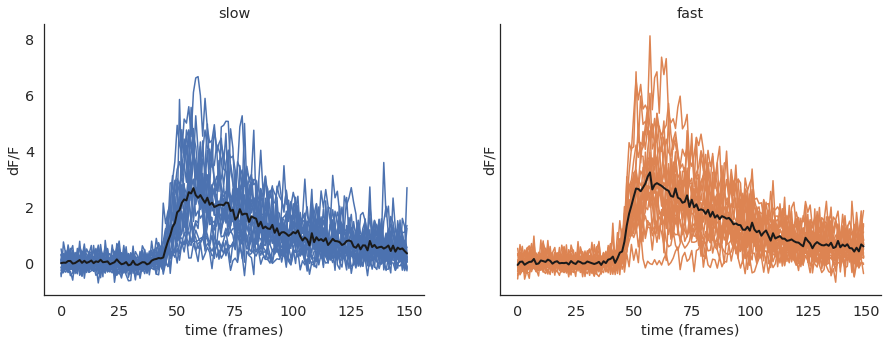

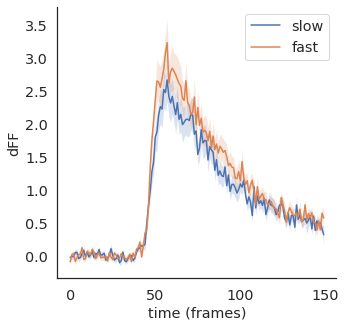

In [7]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'SlowFast_spirals_data', 'spiral_curves.npy'))

color = ['C0', 'C1']
speeds = ['slow', 'fast']

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

for speed_i, speed in enumerate(speeds):
    
    speed_traces = all_traces[:, speed_i, :]

    for i, response in enumerate(speed_traces):
        
        axes[speed_i].plot(response, color=color[speed_i]);
        axes[speed_i].set_ylabel('dF/F');
        axes[speed_i].set_xlabel('time (frames)');
        axes[speed_i].set_title(speeds[speed_i])
    
    mean_response = np.nanmean(speed_traces, axis=0)
    axes[speed_i].plot(mean_response, 'k', lw=2)

# save_path = os.path.join(qnap_path, 'Analysis',  'OPSF_vs_PPSF', '6mW_slowFast_spirals')
# plt.savefig(save_path + '.png', bbox_inches='tight')
# plt.savefig(save_path + '.svg', bbox_inches='tight')
    
plt.figure(figsize=(5,5))
mean, std, ci, sem = meanError(all_traces, axis=0)
x = np.arange(0,150)

for m, sem in zip(mean, sem):
    plt.plot(x, m.T);
    plt.fill_between(x, m + sem, m - sem, alpha=0.2, zorder=1)
    plt.legend(['slow', 'fast'])
    plt.xlabel('time (frames)')
    plt.ylabel('dFF')
    
# save_path = os.path.join(qnap_path, 'Analysis',  'OPSF_vs_PPSF', '6mW_slowFast_spirals_avg')
# plt.savefig(save_path + '.png', bbox_inches='tight')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

### Processing for power test

In [7]:
# To do:
# - Find paq and data files in folder and pair them together
# - Find imaging start and crop paq to that start time
# - Find stim times offset for start of imaging
# - Find frames stim occurred on based on 30 Hz frame rate and 10 kHz sampling rate, and 250 ms stim duration (add enough frames to be safe)
# - DONT FORGET 2 CHANNEL IMAGING, SO TAKE EVERY OTHER FRAME FIRST (DEINTERLEAVE)
# - Load tiff
# - Take pixels corresponding to ROI of interest (pixels delineated by .csv from imagej?)
# - Average those pixels across the stack to form 1D trace of cell in that trial
# - STA using frames calculated earlier, pre, post, average
# GET ALL STIMS ASSOCIATED WITH ONE CELL TO PLOT A SINGLE PPSF ACROSS OPSF?

cells_to_analyse = np.arange(11,12)

for cell in cells_to_analyse:
    input_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_2', 'Cell' + str(cell))
    output_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_2', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_list = os.listdir(input_dir)
    file_list.sort()

    for file in file_list:
        if '.paq' in file: 

            print(file, '.........', end='\r')
            paq = paq_read(os.path.join(input_dir, file))
            
            samples = thresh_signal(paq['data'][0,100000:], 0.11, direction='less') #stim can't happen until at least 10 seconds after recording start

            stim_samples = [] 

            for i, sample in enumerate(samples[:-1]):
                if i==0: 
                    stim_samples.append(sample) #don't do calculation on first thresholded sample
                elif sample - samples[i-1] > 5000:
                    stim_samples.append(sample) #include all thresholded samples that are 5000 samples from any other

            if stim_samples[0] == 0:
                stim_samples = stim_samples[1:] #remove the first thresholded sample if it is 0

            stim_samples = np.array(stim_samples[:3]) + 98000 #add back on the 10 seconds we took at the start, but put samples at the start, rather than end of the stim

            imaging_start = thresh_signal(paq['data'][1,:], 1, direction='more')

            stim_start_frames = np.round((stim_samples - imaging_start)/(10000/30))
            stim_dur_frames = np.ceil(250*(1/30))

            # check stim start frames are roughly 300, 600, 900

            assert len(stim_start_frames) == 3, 'fewer than 3 stims, should be exactly 3'
            assert stim_start_frames[0] > 50, 'first stim frame too soon (before imaging frame 50)'
            assert np.all(np.diff(stim_start_frames) > 150), 'timing between stims is too close (fewer than 150 frames)'

            file = os.path.splitext(file)[0]
            filters = file.split('_')[1:] + ['.tif']
            
            try: 
                
                for f in file_list:
                    if all(s in f for s in filters):
                        cell_stack = ScanImageTiffReader(os.path.join(input_dir, f)).data()
                        cell_stack = cell_stack[0::2]
                        cell_stack[np.where(cell_stack<0)] = 0

                        avg_raw_img = np.mean(cell_stack, axis=0)

                        avg_raw_img = avg_raw_img.astype(np.int16)

                        tf.imwrite(os.path.join(output_dir, file + '_avg_rawGCaMP_image.tif'), avg_raw_img)

                        pre_frames = 45
                        post_frames = 105

                        trial_stack = np.empty([0, pre_frames+post_frames, 512, 512]).astype(np.int16)

                        for stim in np.array(stim_start_frames, dtype='int'):
                            if stim > 46:
                                trial_frames = np.s_[stim-pre_frames : stim+post_frames]
                            else:
                                trial_frames = np.s_[0 : stim+post_frames]

                            trial = cell_stack[trial_frames]
                            trial = np.expand_dims(trial,axis=0)

                            trial_stack = np.append(trial_stack, trial, axis=0)

                        avg_movie = trial_stack.mean(axis=0).astype(np.int16)                
                        tf.imwrite(os.path.join(output_dir, file + '_STA.tif'), avg_movie)

                        gc.collect()
                        
            except: 
                    
                print('could not complete stim processing for cell' + str(cell))
    #                 baseline = avg_movie[range(pre_frames), ...].mean(axis=0)
    #                 norm_movie = ((avg_movie - baseline) / baseline) 
    #                 norm_movie = sta.remove_inf_nan(norm_movie)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA.tif'), norm_movie.astype(np.int32))

    #                 avg_img_frames = range(60, 120)                
    #                 avg_img_dff = sta.make_avg_image(norm_movie, avg_img_frames).astype(np.int16)
    #                 tf.imwrite(os.path.join(output_dir, file + '_dff_STA_avgImg.tif'), avg_img_dff)

(355000, 370000)

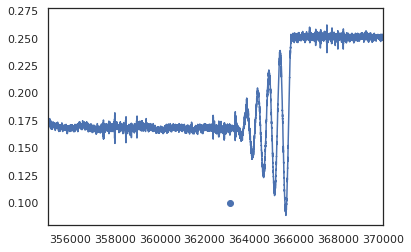

In [24]:
# samples = thresh_signal(paq['data'][0,100000:], 0.11, direction='less')

# stim_samples = [] 

# for i, sample in enumerate(samples[:-1]):
#     if i==0: 
#         stim_samples.append(sample) #don't do calculation on first thresholded sample
#     elif sample - samples[i-1] > 5000:
#         stim_samples.append(sample) #include all thresholded samples that are 5000 samples from any other

# if stim_samples[0] == 0:
#     stim_samples = stim_samples[1:] #remove the first thresholded sample if it is 0

# stim_samples = np.array(stim_samples[:3]) + 98000 #add back on the 10 seconds we took at the start, but put samples at the start, rather than end of the stim

plt.plot(paq['data'][0,:])
plt.scatter(stim_samples, np.repeat(0.1,len(stim_samples)))
# plt.xlim([355000,370000])

In [13]:
cells_to_analyse = np.arange(1,39)

all_traces = np.full([len(cells_to_analyse), 150], np.nan)
all_powers = np.empty([len(cells_to_analyse)], dtype='object')

for cell_i, cell in enumerate(cells_to_analyse):
    roi_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_2', 'Cell' + str(cell), 'Imagej_output')
    input_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_2', 'Cell' + str(cell), 'Imagej_output')
    output_dir = os.path.join(qnap_path, 'Axial_res_PPSF_data_2', 'Cell' + str(cell), 'Python_output')
    
    if not os.path.exists(input_dir):
        continue
        
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    roi_file_list = os.listdir(roi_dir)
    roi_file_list.sort()
    
    for f in roi_file_list:
        if '.roi' in f:
            roi = read_roi_file(os.path.join(roi_dir, f))
            (roi_key,roi_value), = roi.items()
    
    file_list = os.listdir(input_dir)
    file_list.sort()
    
    for f in file_list:
        if 'dff.tif' in f:
            print('Loading', f, '........', end='\r')
            dff_stack = tf.imread(os.path.join(input_dir, f))
            
            x_roi = np.array(roi_value['x'])
            y_roi = np.array(roi_value['y']) 

            x, y = np.meshgrid(np.arange(512), np.arange(512)) # make a canvas with coordinates
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T 

            coords = list(zip(x_roi,y_roi))
            p = Path(coords) # make a polygon
            grid = p.contains_points(points)
            mask = grid.reshape(512,512) # now you have a mask with points inside a polygon

            cell_coords = np.where(mask)

            dff_stack = sta.remove_inf_nan(dff_stack)
            trace = np.nanmean(dff_stack[:, cell_coords[0], cell_coords[1]], axis=1)
            all_traces[cell_i] = trace
            all_powers[cell_i] = f.split('_')[3]
    
np.save(os.path.join(qnap_path, 'Axial_res_PPSF_data_2', 'power_test_curves.npy'), all_traces)
np.save(os.path.join(qnap_path, 'Axial_res_PPSF_data_2', 'powers.npy'), all_powers)

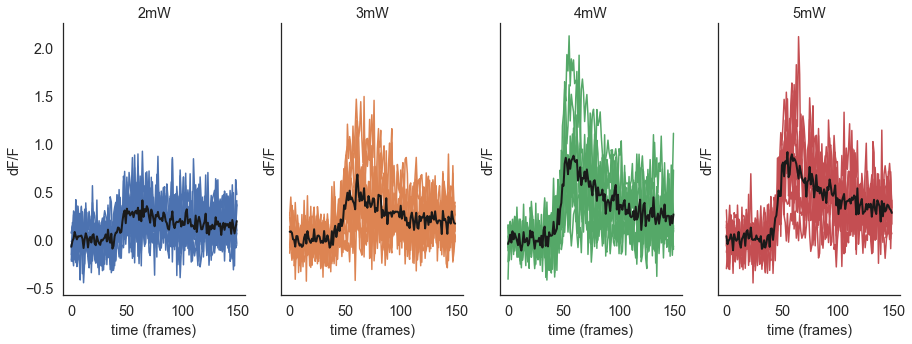

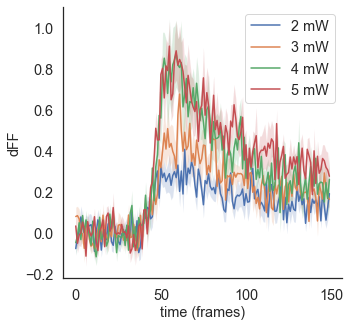

In [338]:
all_traces = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_2', 'power_test_curves.npy'))
all_powers = np.load(os.path.join(qnap_path, 'Analysis', 'OPSF_vs_PPSF', 'Scientifica_large_mid_OPSF', 'Axial_res_PPSF_data_2', 'powers.npy'), allow_pickle=True)

first_power = np.where(all_powers == '2mW')[0]
second_power = np.where(all_powers == '3mW')[0]
third_power = np.where(all_powers == '4mW')[0]
fourth_power = np.where(all_powers == '5mW')[0]

color = ['C0', 'C1', 'C2', 'C3']
powers = ['2mW', '3mW', '4mW', '5mW']

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(15,5))

for power_i, power in enumerate([first_power, second_power, third_power, fourth_power]):
    
    power_traces = all_traces[power]

    for response in power_traces:
        axes[power_i].plot(response, color=color[power_i]);#
        axes[power_i].set_ylabel('dF/F');
        axes[power_i].set_xlabel('time (frames)');
        axes[power_i].set_title(powers[power_i])
    
    mean_response = np.nanmean(power_traces, axis=0)
    axes[power_i].plot(mean_response, 'k', lw=2)
#     axes[power_i].set_ylim([-0.5, 1])

plt.figure(figsize=(5,5))

for power_i, power in enumerate([first_power, second_power, third_power, fourth_power]):
    
    power_traces = all_traces[power]
    
    mean, std, ci, sem = meanError(power_traces, axis=0)
    x = np.arange(0,150)
    
    plt.plot(x, mean.T);
    plt.fill_between(x, mean + sem, mean - sem, alpha=0.2, zorder=1)
    plt.legend(['2 mW', '3 mW', '4 mW', '5 mW'])
    plt.xlabel('time (frames)')
    plt.ylabel('dFF')
    
# save_path = fig_save_path + '_power_test_responses'
# savePlot(save_path)